In [1]:
# take 10% of images from each class to validation

In [2]:
# there are B&W images in data!

In [3]:
import os
from datetime import datetime
from typing import Tuple
from time import monotonic
from functools import cache

# from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset

import torch
from torch import nn

from torch import optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm
num_cpus = os.cpu_count()
half_cpus = num_cpus - 2

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda:0'

### Data

In [4]:

class TinyImageNetDataset(Dataset):
    def __init__(self, 
                 img_dir: str, 
                 annotations: list[Tuple[str, str]],
                 transform=None,
                 augment_transform=None, 
                 target_transform=None):
        self.img_dir = img_dir
        self.annotations = annotations
        self.transform = transform
        self.target_transform = target_transform
        self.augment_transform = augment_transform

    def __len__(self):
        return len(self.annotations)

    @cache
    def get_image(self, path) -> Image:
        image = Image.open(path).convert('RGB')
        return image

    def __getitem__(self, idx):
        file_name, label = self.annotations[idx]
        img_path = os.path.join(self.img_dir, label, 'images', file_name)
        image = self.get_image(img_path)
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
# TEMP. check with data
source_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/train'
from pathlib import Path
img_dir = Path(source_folder)
img_dir.exists()
# for c in img_dir.iterdir():
    # for f in (c / "images").iterdir():
        # print(f)
        # break
    # break

# for class_name in img_dir.iterdir():
    # print(len(list((class_name / "images").iterdir())))


# 

True

In [6]:
# for debugging - will remove
N_CLASSES_TO_USE = 200

source_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/train'

train_split = []
val_split = []

# TODO ? maybe use cross-validation somehow? Looks like model will never train on last 50 images. Or it is okay?
class_names = os.listdir(source_folder)
for class_name in class_names[:N_CLASSES_TO_USE]:
    file_names = os.listdir(f'{source_folder}/{class_name}/images')
    file_ids = [int(name.split('.')[0].split('_')[1]) for name in file_names]

    train_names = [file_names[i] for i in range(len(file_names)) if file_ids[i] < 450]
    val_names = [file_names[i] for i in range(len(file_names)) if file_ids[i] >= 450]
    # print(f"val_names:{val_names}")

    train_split.extend((name, class_name) for name in train_names)
    val_split.extend((name, class_name) for name in val_names)

In [7]:
print(len(train_split + val_split))
# print(train_split[0])
# print(len(train_split), len(val_split))

100000


In [8]:
# TODO ? why and what we are doing by T.Normalize
# Normalization values for mean and std based on data


temp_dataset = TinyImageNetDataset(source_folder, train_split + val_split, transform=T.ToTensor())
temp_dataloader = DataLoader(temp_dataset, batch_size=128, shuffle=False, num_workers=half_cpus)
mean = torch.zeros(3).to(DEVICE)
std = torch.zeros(3).to(DEVICE)
n_samples = 0

# Iterate through the dataset
for images, _ in temp_dataloader:
    images = images.to(DEVICE)
    # Reshape images to (batch_size, 3, height, width)
    images = images.view(images.size(0), images.size(1), -1)
    n_samples += images.size(0)
    
    # Sum up the pixel values for each channel
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

# Calculate the mean and standard deviation
mean /= n_samples
std /= n_samples

mean = mean.cpu()
std = std.cpu()

print(f'Mean: {mean}')
print(f'Std: {std}')

train_img_transform = T.Compose([
    T.ToTensor(),
    T.RandomRotation([-30, 30]),
    T.RandomHorizontalFlip(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    # T.Normalize(mean, std)
])
augment_transform = T.Compose([
    T.RandomHorizontalFlip(p=1.0)  # Always flip the image
])

val_img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    # T.Normalize(mean, std)
])

# TODO ? why do we need dict with IDs and back
class_name_to_id_dict = {name: i for i, name in enumerate(class_names)}
class_id_to_name_dict = {i: name for name, i in class_name_to_id_dict.items()}

label_to_id_transform = lambda name: class_name_to_id_dict[name]

Mean: tensor([0.4802, 0.4481, 0.3975])
Std: tensor([0.2296, 0.2263, 0.2255])


In [9]:
train_dataset = TinyImageNetDataset(source_folder,
                                    train_split,
                                    transform=train_img_transform,
                                    target_transform=label_to_id_transform,
                                    augment_transform=augment_transform
                                    )

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=half_cpus, pin_memory=True)

In [10]:
# TODO ? do we need also to shuffle the val dataset?
val_dataset = TinyImageNetDataset(source_folder,
                                  val_split,
                                  transform=val_img_transform,
                                  target_transform=label_to_id_transform
                                    )

val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=half_cpus, pin_memory=True)

In [11]:
# TODO ? what is Y here? why it is 128 values. It should be class value, no?
X, Y = next(iter(train_dataloader))
X.shape, Y.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

---

### Model

In [12]:
# TODO ? just fun, why 42?
def set_seed(seed: int = 42) -> None:
    # np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

def get_number_of_trainable_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:

def conv_block(num_channels, growth_rate) -> nn.Sequential:
    return nn.Sequential(
        nn.BatchNorm2d(num_channels),
        nn.ReLU(),
        nn.Conv2d(num_channels, growth_rate, kernel_size=3, padding=1))


class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels, growth_rate):
        super().__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels + i * growth_rate, growth_rate))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)
        return X


def transition_block(num_channels, out_channels):
    return nn.Sequential(
        nn.BatchNorm2d(num_channels),
        nn.ReLU(),
        nn.Conv2d(num_channels, out_channels, kernel_size=1),
        nn.MaxPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    def __init__(self, growth_rate=16, num_classes=200):
        super().__init__()
        num_channels = 3
        self.block1 = DenseBlock(num_convs=4, num_channels=3, growth_rate=growth_rate)
        num_channels += 4 * growth_rate
        self.trans1 = transition_block(num_channels=num_channels, out_channels=num_channels // 2)
        num_channels //= 2

        self.block2 = DenseBlock(num_convs=4, num_channels=num_channels, growth_rate=growth_rate)
        num_channels += 4 * growth_rate
        self.trans2 = transition_block(num_channels=num_channels, out_channels=num_channels // 2)
        num_channels //= 2

        self.block3 = DenseBlock(num_convs=4, num_channels=num_channels, growth_rate=growth_rate)
        num_channels += 4 * growth_rate
        self.trans3 = transition_block(num_channels=num_channels, out_channels=num_channels // 2)
        num_channels //= 2

        self.block4 = DenseBlock(num_convs=4, num_channels=num_channels, growth_rate=growth_rate)
        num_channels += 4 * growth_rate
        
        self.drop1 = nn.Dropout(p=0.2)
        self.fc = nn.Linear(num_channels * 8 * 8, num_classes)
        
    def forward(self, x):

        # print(f"block1 Input shape: {x.shape}")
        x = self.block1(x)
        # print(f"trans1 Input shape: {x.shape}")
        x = self.trans1(x)
        # print(f"block2 Input shape: {x.shape}")

        x = self.block2(x)
        # print(f"trans2 Input shape: {x.shape}")
        x = self.trans2(x)
        # print(f"block3 Input shape: {x.shape}")

        x = self.block3(x)
        # print(f"trans3 Input shape: {x.shape}")
        x = self.trans3(x)
        # print(f"block4 Input shape: {x.shape}")

        x = self.block4(x)
        # print(f"flatten Input shape: {x.shape}")

        x = torch.flatten(x, 1)
        # print(f"drop1 Input shape: {x.shape}")
        x = self.drop1(x)
        # print(f"fc Input shape: {x.shape}")
        x = self.fc(x)
        # print(f"fc output shape: {x.shape}")
        return x

In [14]:
# 3x64x64 -> (conv1) -> 32x32x32 -> (conv2) -> 64x16x16 -> (conv3) -> 128x8x8 -> (conv4) -> 64x4x4=1024

In [15]:
# class DenseNetModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = DenseNetBlock(3, 16, kernel_size=1)
#         self.conv2 = DenseNetBlock(32, 64, kernel_size=1)
#         self.conv3 = DenseNetBlock(128, 128, kernel_size=1)
#         self.conv4 = DenseNetBlock(256, 64, kernel_size=1)

#         self.drop1 = nn.Dropout(p=0.2)
#         self.fc1 = FcBlock(64 * 4 * 4, 512, do_batchnorm=True, activation=nn.ReLU())

#         self.drop2 = nn.Dropout(p=0.1)
#         self.fc2 = FcBlock(512, 200, do_batchnorm=True)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)

#         x = torch.flatten(x, 1)

#         x = self.drop1(x)
#         x = self.fc1(x)

#         x = self.drop2(x)
#         x = self.fc2(x)
#         return x

---

### Train

In [16]:
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE

In [17]:
set_seed(123)

model = DenseNet()
dummy_input = torch.randn(1, 3, 64, 64)
output = model(dummy_input)
print(f"Output shape: {output.shape}")
print(get_number_of_trainable_params(model))

for layer in model.named_parameters():
    print(layer[0], layer[1].numel())

model.to(DEVICE)

Random seed set as 123
Output shape: torch.Size([1, 200])
1688108
block1.net.0.0.weight 3
block1.net.0.0.bias 3
block1.net.0.2.weight 432
block1.net.0.2.bias 16
block1.net.1.0.weight 19
block1.net.1.0.bias 19
block1.net.1.2.weight 2736
block1.net.1.2.bias 16
block1.net.2.0.weight 35
block1.net.2.0.bias 35
block1.net.2.2.weight 5040
block1.net.2.2.bias 16
block1.net.3.0.weight 51
block1.net.3.0.bias 51
block1.net.3.2.weight 7344
block1.net.3.2.bias 16
trans1.0.weight 67
trans1.0.bias 67
trans1.2.weight 2211
trans1.2.bias 33
block2.net.0.0.weight 33
block2.net.0.0.bias 33
block2.net.0.2.weight 4752
block2.net.0.2.bias 16
block2.net.1.0.weight 49
block2.net.1.0.bias 49
block2.net.1.2.weight 7056
block2.net.1.2.bias 16
block2.net.2.0.weight 65
block2.net.2.0.bias 65
block2.net.2.2.weight 9360
block2.net.2.2.bias 16
block2.net.3.0.weight 81
block2.net.3.0.bias 81
block2.net.3.2.weight 11664
block2.net.3.2.bias 16
trans2.0.weight 97
trans2.0.bias 97
trans2.2.weight 4656
trans2.2.bias 48
bloc

DenseNet(
  (block1): DenseBlock(
    (net): Sequential(
      (0): Sequential(
        (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Sequential(
        (0): BatchNorm2d(19, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(19, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Sequential(
        (0): BatchNorm2d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(35, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): Sequential(
        (0): BatchNorm2d(51, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(51, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (trans1): Sequential(
    (0): BatchNorm2

In [ ]:
train_config = {
    'n_epochs': 100,
    'lr': 0.008,
    'batch_size': 256,
}

optimizer = optim.AdamW(model.parameters(), lr=train_config['lr'],)
scheduler = ReduceLROnPlateau(optimizer, patience=1, factor=0.2, verbose="True", min_lr=1e-4)
criterion = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

best_checkpoint_path = '../working/best.pth'

/home/vpashchenkov/mine/flg_ml24-cnn/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
def do_train_epoch(model: nn.Module, 
                   criterion: nn.Module,
                   optimizer,
                   train_loader: DataLoader, 
                   verbose: int = -1) -> Tuple[float, float]:
    total_steps = len(train_dataloader)
    
    running_loss, step = 0, 0
    n_correct_predictions, total_predictions = 0, 0
    for X, Y in train_loader:
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)
        optimizer.zero_grad()
    
        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        optimizer.step()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
    
        running_loss += loss.item()
        step += 1

        if verbose > 0 and step % verbose == 0:
            cur_time = datetime.now().strftime("%H:%M:%S")
            print(f"[{cur_time}] Step {step}/{total_steps}: train loss = {round(running_loss / step, 5)}")

        total_predictions += len(Y)

        probs = F.softmax(preds, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)
        n_correct_predictions += (predicted_labels == Y).sum().item()
    
    avg_loss = round(running_loss / step, 5)
    accuracy = round(n_correct_predictions / total_predictions, 5)
    print(f"Train loss = {avg_loss}, accuracy = {accuracy}, lr: {optimizer.param_groups[0]['lr']}")
    return avg_loss, accuracy

In [20]:
def do_val_epoch(model: nn.Module,
                 criterion: nn.Module,
                 val_loader: DataLoader) -> Tuple[float, float]:
    total_steps = len(val_loader)
    
    running_loss = 0
    n_correct_predictions, total_predictions = 0, 0
    
    with torch.no_grad():
        for X, Y in val_loader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)
            preds = model(X)
            loss = criterion(preds, Y)
    
            running_loss += loss.item()
            total_predictions += len(Y)
    
            probs = F.softmax(preds, dim=1)
            predicted_labels = torch.argmax(probs, dim=1)
            n_correct_predictions += (predicted_labels == Y).sum().item()

    avg_loss = round(running_loss / total_steps, 5)
    accuracy = round(n_correct_predictions / total_predictions, 5)

    print(f'VALIDATION LOSS = {avg_loss}, VALIDATION ACCURACY = {accuracy}')
    
    return avg_loss, accuracy
          

In [21]:
def plot_history(history: dict):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].plot(history['train_loss'], marker='o', label='Train Loss')
    ax[0].plot(history['test_loss'], marker='o', label='Test Loss')
    ax[0].set_title('Loss per epoch')
    ax[0].legend()
    
    ax[1].plot(history['train_accuracy'], marker='o', label='Train Accuracy')
    ax[1].plot(history['test_accuracy'], marker='o', label='Test Accuracy')
    ax[1].set_title('Accuracy per epoch')
    ax[1].legend()
    
    plt.show()


 		 ------------------------------ EPOCH: 1 ------------------------------
[04:27:12] Step 20/176: train loss = 17.48171
[04:27:23] Step 40/176: train loss = 12.62627
[04:27:34] Step 60/176: train loss = 10.86541
[04:27:45] Step 80/176: train loss = 9.95771
[04:27:57] Step 100/176: train loss = 9.67535
[04:28:08] Step 120/176: train loss = 9.67904
[04:28:20] Step 140/176: train loss = 9.47516
[04:28:32] Step 160/176: train loss = 9.18785
Train loss = 9.09513, accuracy = 0.00677, lr: 0.008
VALIDATION LOSS = 6.05624, VALIDATION ACCURACY = 0.0071
LR: [0.008]


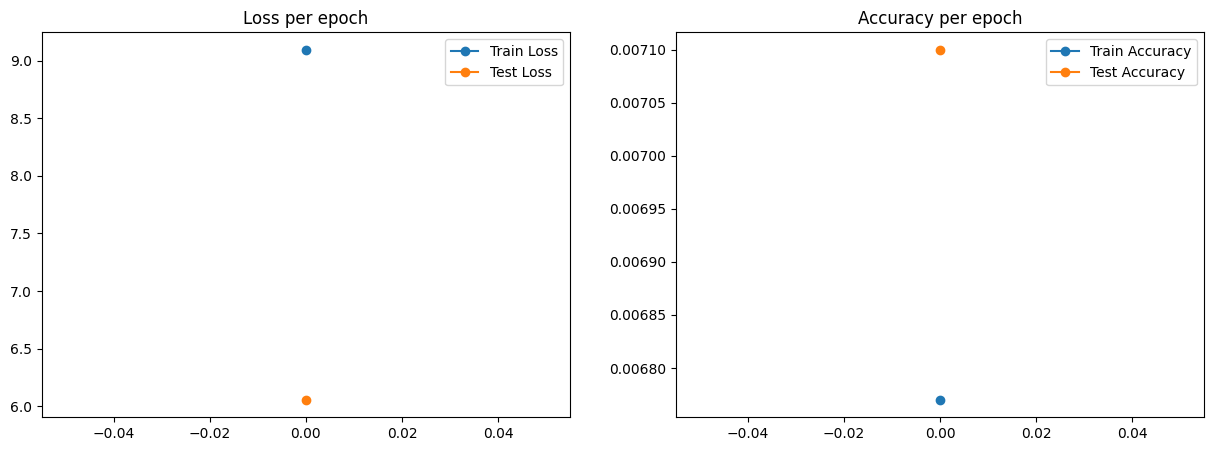

Saving best model

 		 ------------------------------ EPOCH: 2 ------------------------------
[04:28:56] Step 20/176: train loss = 7.75613
[04:29:05] Step 40/176: train loss = 7.57474
[04:29:15] Step 60/176: train loss = 7.45547
[04:29:25] Step 80/176: train loss = 7.30807
[04:29:36] Step 100/176: train loss = 7.14651
[04:29:45] Step 120/176: train loss = 6.99117
[04:29:54] Step 140/176: train loss = 6.86835
[04:30:05] Step 160/176: train loss = 6.78984
Train loss = 6.70858, accuracy = 0.01137, lr: 0.008
VALIDATION LOSS = 7.75877, VALIDATION ACCURACY = 0.0074
LR: [0.008]


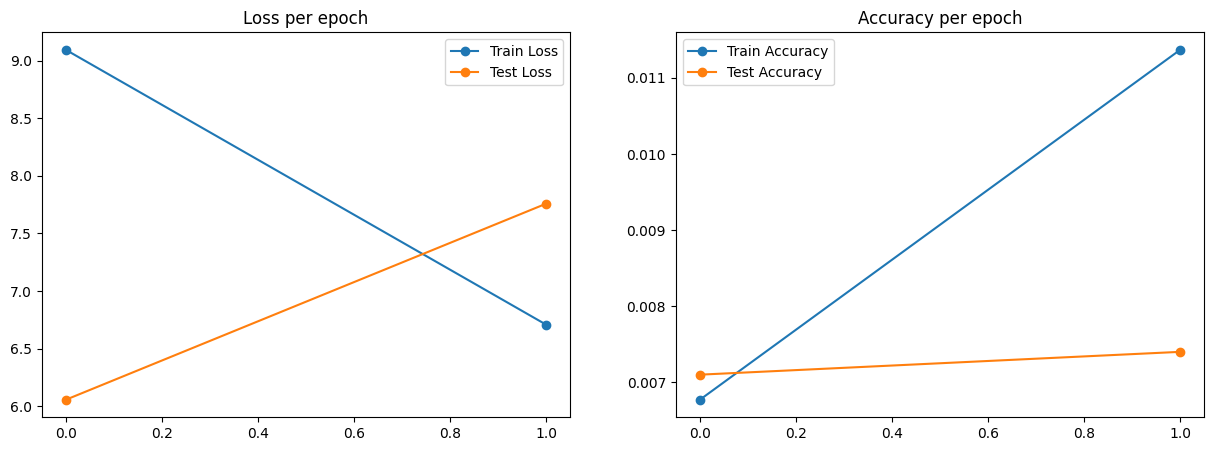

Validation loss didn't improve

 		 ------------------------------ EPOCH: 3 ------------------------------
[04:30:26] Step 20/176: train loss = 5.70091
[04:30:36] Step 40/176: train loss = 5.60705
[04:30:46] Step 60/176: train loss = 5.56318
[04:30:55] Step 80/176: train loss = 5.50739
[04:31:05] Step 100/176: train loss = 5.44807
[04:31:15] Step 120/176: train loss = 5.39064
[04:31:25] Step 140/176: train loss = 5.33696
[04:31:33] Step 160/176: train loss = 5.28706
Train loss = 5.24872, accuracy = 0.03066, lr: 0.008
VALIDATION LOSS = 5.19941, VALIDATION ACCURACY = 0.0369
LR: [0.008]


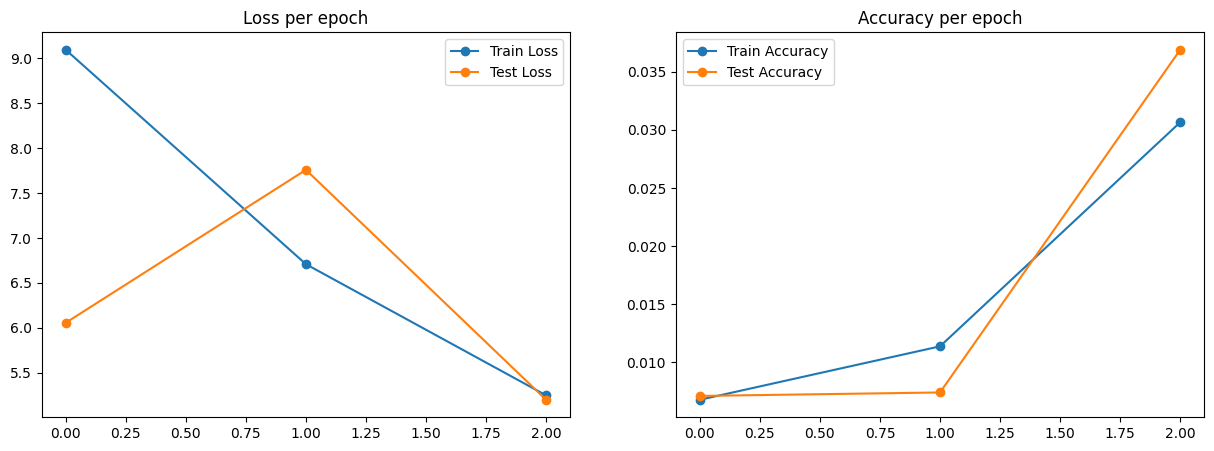

Saving best model

 		 ------------------------------ EPOCH: 4 ------------------------------
[04:31:52] Step 20/176: train loss = 4.77203
[04:32:02] Step 40/176: train loss = 4.7836
[04:32:11] Step 60/176: train loss = 4.75888
[04:32:21] Step 80/176: train loss = 4.73923
[04:32:30] Step 100/176: train loss = 4.72137
[04:32:39] Step 120/176: train loss = 4.70187
[04:32:48] Step 140/176: train loss = 4.68364
[04:32:57] Step 160/176: train loss = 4.66849
Train loss = 4.65498, accuracy = 0.06933, lr: 0.008
VALIDATION LOSS = 5.30032, VALIDATION ACCURACY = 0.0469
LR: [0.008]


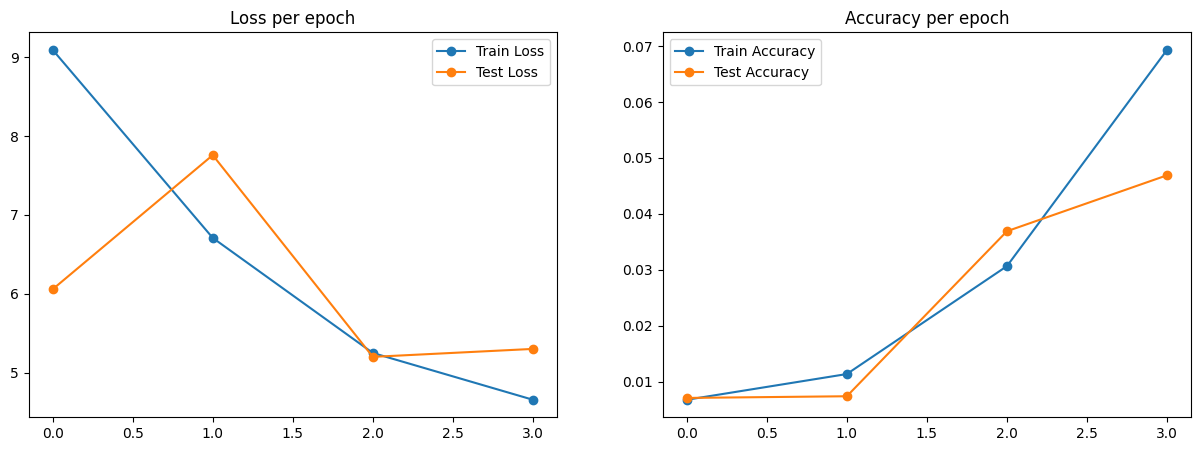

Validation loss didn't improve

 		 ------------------------------ EPOCH: 5 ------------------------------
[04:33:15] Step 20/176: train loss = 4.46591
[04:33:25] Step 40/176: train loss = 4.44717
[04:33:36] Step 60/176: train loss = 4.4247
[04:33:45] Step 80/176: train loss = 4.40202
[04:33:55] Step 100/176: train loss = 4.38454
[04:34:04] Step 120/176: train loss = 4.36849
[04:34:14] Step 140/176: train loss = 4.35077
[04:34:24] Step 160/176: train loss = 4.33906
Train loss = 4.32679, accuracy = 0.10836, lr: 0.008
VALIDATION LOSS = 6.66029, VALIDATION ACCURACY = 0.0538
LR: [0.0016]


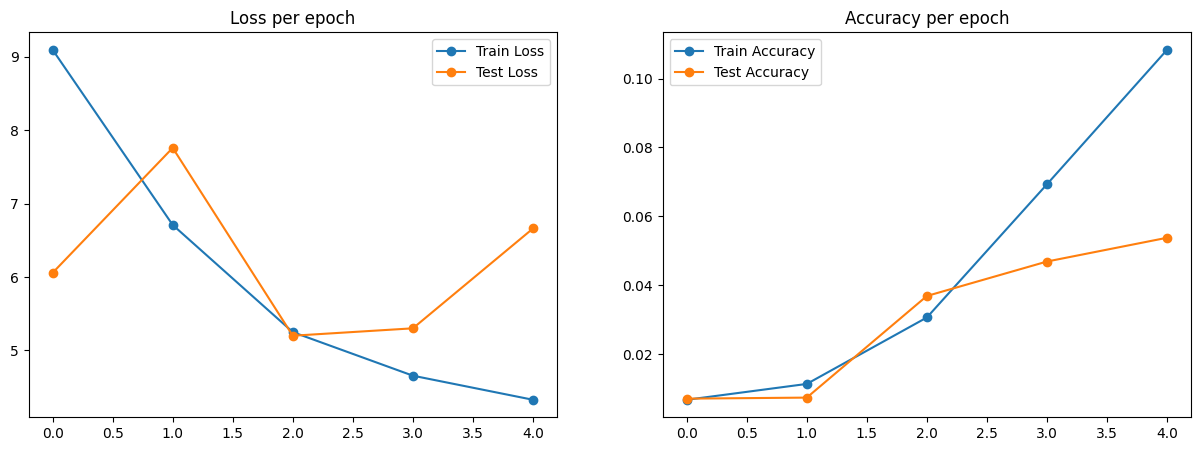

Validation loss didn't improve

 		 ------------------------------ EPOCH: 6 ------------------------------
[04:34:44] Step 20/176: train loss = 4.06484
[04:34:53] Step 40/176: train loss = 4.0487
[04:35:02] Step 60/176: train loss = 4.02839
[04:35:12] Step 80/176: train loss = 4.01901
[04:35:21] Step 100/176: train loss = 4.01338
[04:35:29] Step 120/176: train loss = 4.00623
[04:35:38] Step 140/176: train loss = 3.99985
[04:35:48] Step 160/176: train loss = 3.99443
Train loss = 3.99085, accuracy = 0.15484, lr: 0.0016
VALIDATION LOSS = 3.96257, VALIDATION ACCURACY = 0.1637
LR: [0.0016]


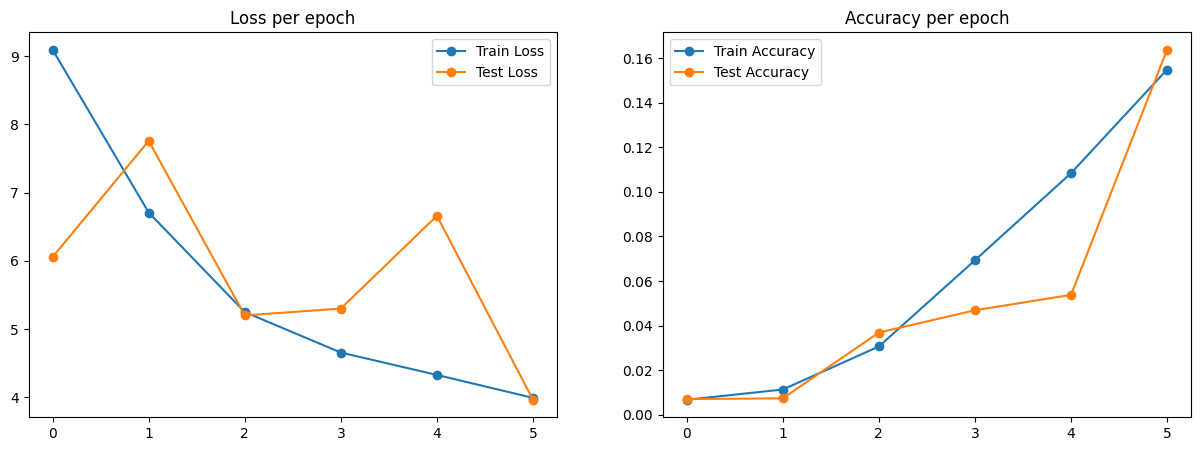

Saving best model

 		 ------------------------------ EPOCH: 7 ------------------------------
[04:36:07] Step 20/176: train loss = 3.92343
[04:36:17] Step 40/176: train loss = 3.91886
[04:36:27] Step 60/176: train loss = 3.91176
[04:36:37] Step 80/176: train loss = 3.91004
[04:36:47] Step 100/176: train loss = 3.90667
[04:36:56] Step 120/176: train loss = 3.90282
[04:37:06] Step 140/176: train loss = 3.89859
[04:37:15] Step 160/176: train loss = 3.89781
Train loss = 3.89547, accuracy = 0.17061, lr: 0.0016
VALIDATION LOSS = 3.90899, VALIDATION ACCURACY = 0.1727
LR: [0.0016]


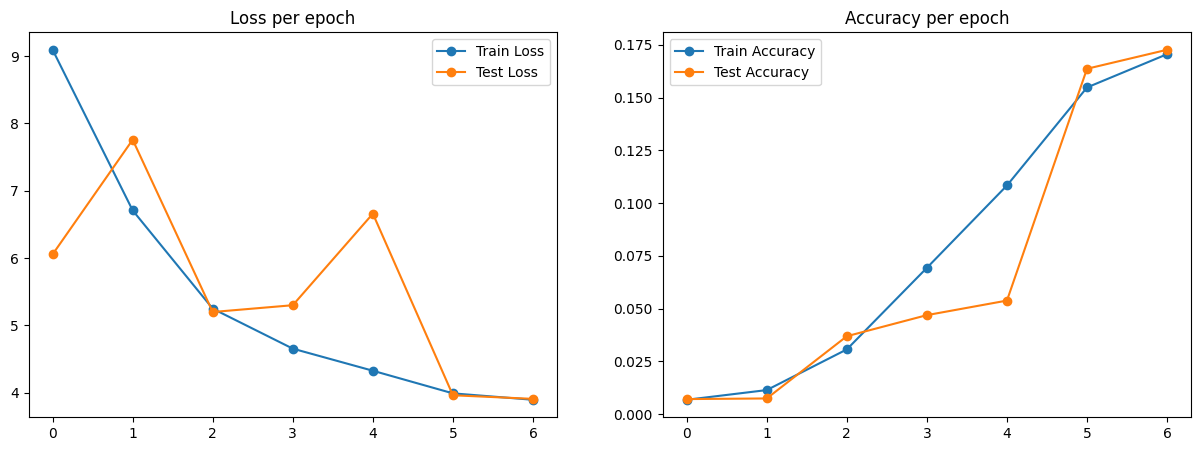

Saving best model

 		 ------------------------------ EPOCH: 8 ------------------------------
[04:37:34] Step 20/176: train loss = 3.81692
[04:37:43] Step 40/176: train loss = 3.82341
[04:37:53] Step 60/176: train loss = 3.83146
[04:38:03] Step 80/176: train loss = 3.8347
[04:38:13] Step 100/176: train loss = 3.83513
[04:38:23] Step 120/176: train loss = 3.83085
[04:38:32] Step 140/176: train loss = 3.83048
[04:38:42] Step 160/176: train loss = 3.83379
Train loss = 3.83054, accuracy = 0.1797, lr: 0.0016
VALIDATION LOSS = 3.84333, VALIDATION ACCURACY = 0.1811
LR: [0.0016]


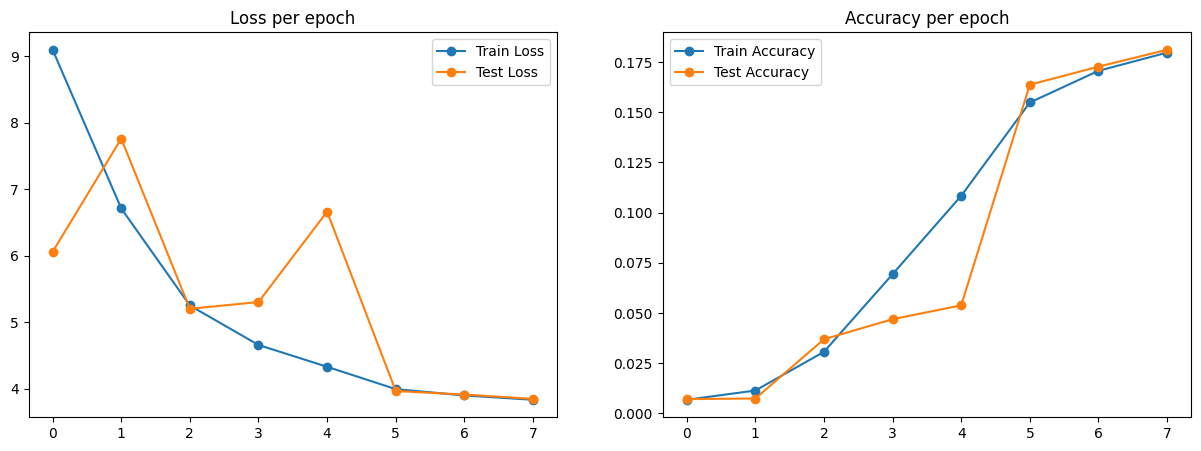

Saving best model

 		 ------------------------------ EPOCH: 9 ------------------------------
[04:39:01] Step 20/176: train loss = 3.77051
[04:39:09] Step 40/176: train loss = 3.77934
[04:39:18] Step 60/176: train loss = 3.77752
[04:39:27] Step 80/176: train loss = 3.77655
[04:39:36] Step 100/176: train loss = 3.77416
[04:39:46] Step 120/176: train loss = 3.77366
[04:39:56] Step 140/176: train loss = 3.77347
[04:40:06] Step 160/176: train loss = 3.76985
Train loss = 3.77044, accuracy = 0.18891, lr: 0.0016
VALIDATION LOSS = 3.89471, VALIDATION ACCURACY = 0.1715
LR: [0.0016]


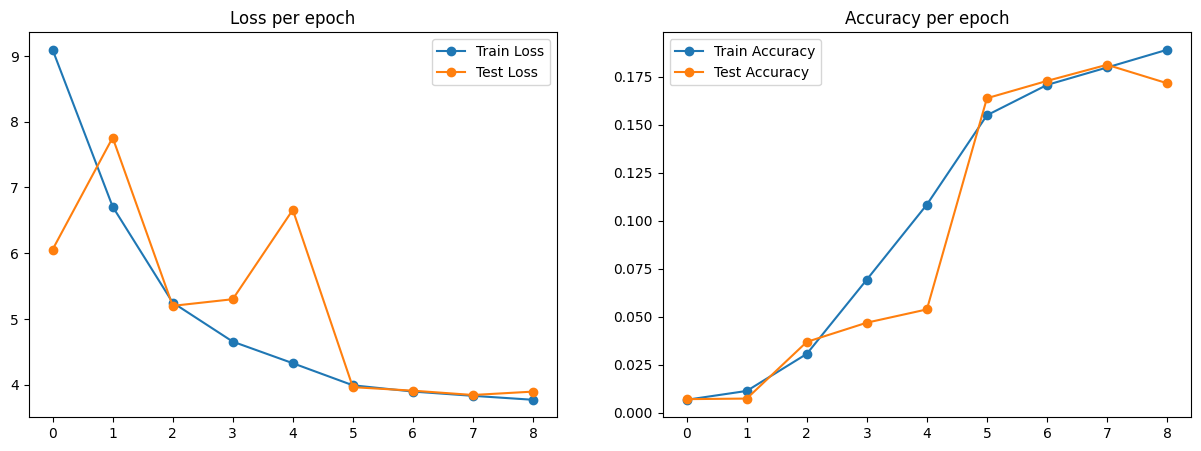

Validation loss didn't improve

 		 ------------------------------ EPOCH: 10 ------------------------------
[04:40:26] Step 20/176: train loss = 3.73019
[04:40:35] Step 40/176: train loss = 3.71812
[04:40:46] Step 60/176: train loss = 3.71718
[04:40:55] Step 80/176: train loss = 3.71999
[04:41:05] Step 100/176: train loss = 3.7234
[04:41:14] Step 120/176: train loss = 3.72456
[04:41:23] Step 140/176: train loss = 3.72253
[04:41:33] Step 160/176: train loss = 3.71886
Train loss = 3.71797, accuracy = 0.19639, lr: 0.0016
VALIDATION LOSS = 3.85862, VALIDATION ACCURACY = 0.1811
LR: [0.00032]


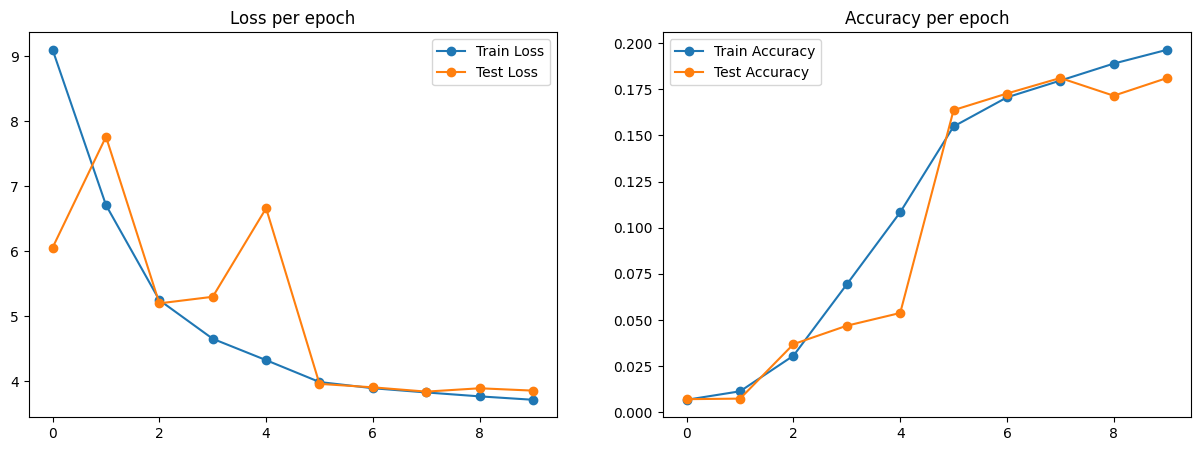

Validation loss didn't improve

 		 ------------------------------ EPOCH: 11 ------------------------------
[04:41:53] Step 20/176: train loss = 3.67153
[04:42:03] Step 40/176: train loss = 3.63536
[04:42:13] Step 60/176: train loss = 3.62234
[04:42:23] Step 80/176: train loss = 3.61861
[04:42:33] Step 100/176: train loss = 3.62024
[04:42:43] Step 120/176: train loss = 3.61441
[04:42:53] Step 140/176: train loss = 3.61203
[04:43:02] Step 160/176: train loss = 3.61221
Train loss = 3.6124, accuracy = 0.21477, lr: 0.00032
VALIDATION LOSS = 3.6557, VALIDATION ACCURACY = 0.213
LR: [0.00032]


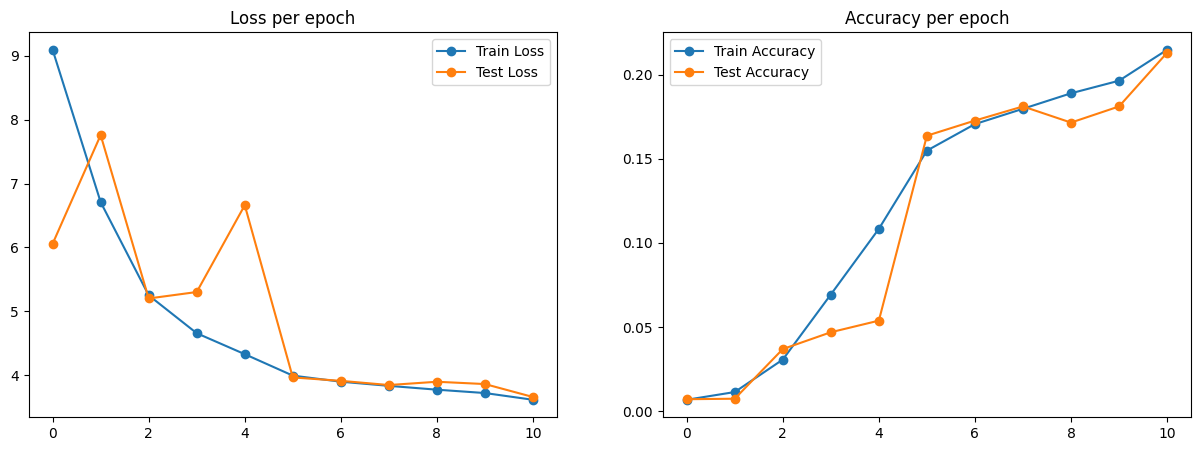

Saving best model

 		 ------------------------------ EPOCH: 12 ------------------------------
[04:43:22] Step 20/176: train loss = 3.55816
[04:43:32] Step 40/176: train loss = 3.56719
[04:43:41] Step 60/176: train loss = 3.56822
[04:43:50] Step 80/176: train loss = 3.57852
[04:43:59] Step 100/176: train loss = 3.58073
[04:44:07] Step 120/176: train loss = 3.58548
[04:44:16] Step 140/176: train loss = 3.58562
[04:44:25] Step 160/176: train loss = 3.58394
Train loss = 3.58389, accuracy = 0.21824, lr: 0.00032
VALIDATION LOSS = 3.63742, VALIDATION ACCURACY = 0.2155
LR: [0.00032]


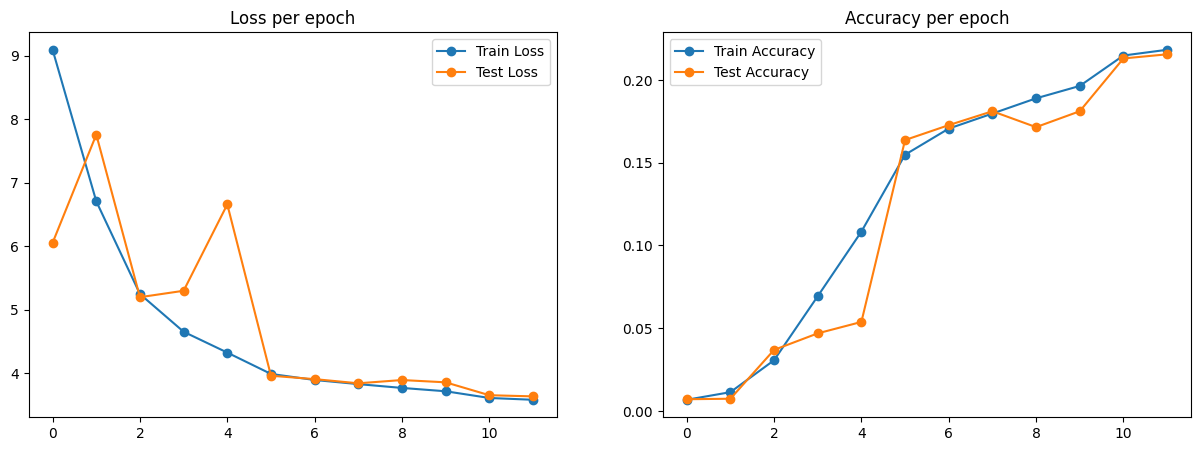

Saving best model

 		 ------------------------------ EPOCH: 13 ------------------------------
[04:44:44] Step 20/176: train loss = 3.57938
[04:44:54] Step 40/176: train loss = 3.57933
[04:45:04] Step 60/176: train loss = 3.58001
[04:45:13] Step 80/176: train loss = 3.57319
[04:45:23] Step 100/176: train loss = 3.56606
[04:45:34] Step 120/176: train loss = 3.56292
[04:45:44] Step 140/176: train loss = 3.56353
[04:45:53] Step 160/176: train loss = 3.56496
Train loss = 3.56453, accuracy = 0.22228, lr: 0.00032
VALIDATION LOSS = 3.62491, VALIDATION ACCURACY = 0.2173
LR: [0.00032]


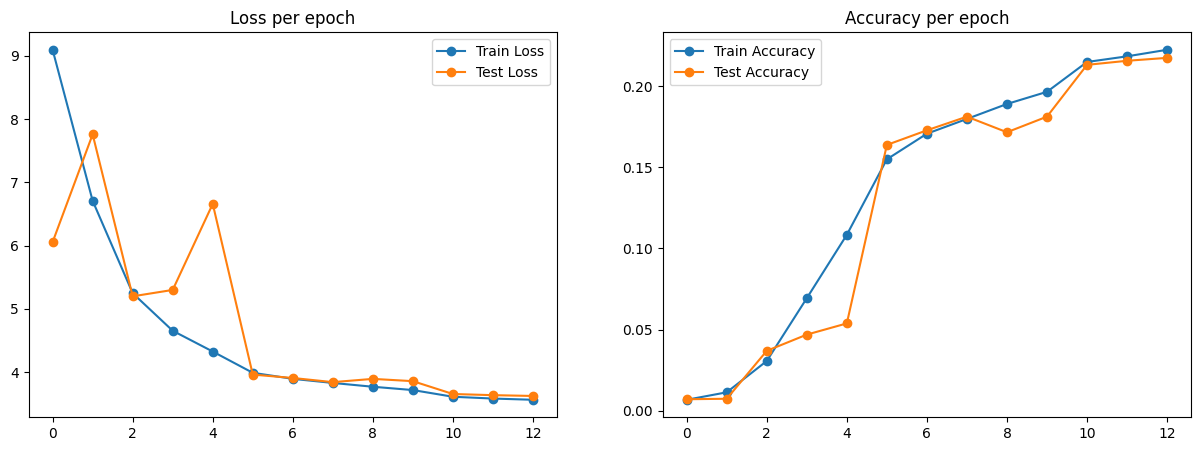

Saving best model

 		 ------------------------------ EPOCH: 14 ------------------------------
[04:46:12] Step 20/176: train loss = 3.54453
[04:46:22] Step 40/176: train loss = 3.5469
[04:46:31] Step 60/176: train loss = 3.54995
[04:46:39] Step 80/176: train loss = 3.5484
[04:46:48] Step 100/176: train loss = 3.55564
[04:46:58] Step 120/176: train loss = 3.55628
[04:47:09] Step 140/176: train loss = 3.54878
[04:47:19] Step 160/176: train loss = 3.5501
Train loss = 3.55039, accuracy = 0.22562, lr: 0.00032
VALIDATION LOSS = 3.60869, VALIDATION ACCURACY = 0.2183
LR: [0.00032]


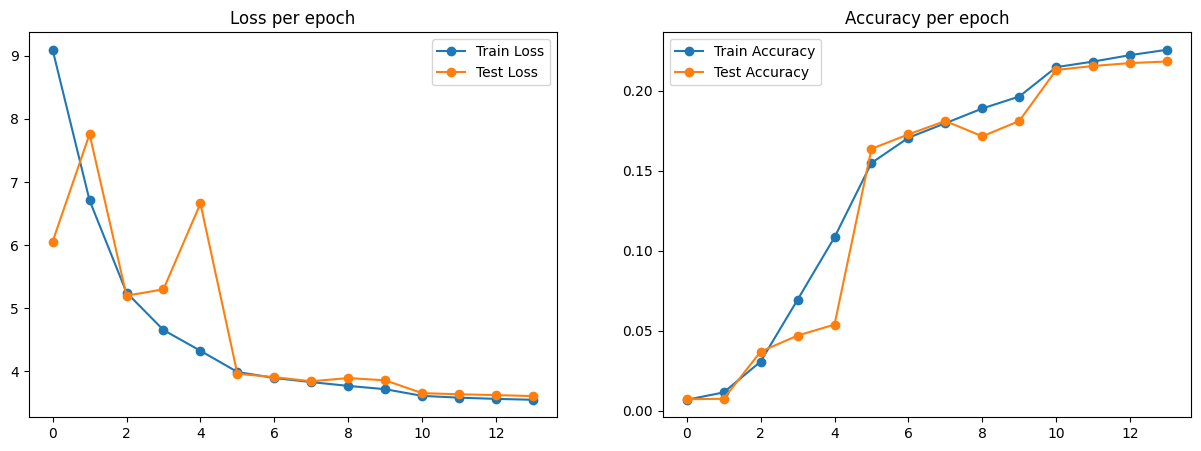

Saving best model

 		 ------------------------------ EPOCH: 15 ------------------------------
[04:47:39] Step 20/176: train loss = 3.5207
[04:47:50] Step 40/176: train loss = 3.51794
[04:47:59] Step 60/176: train loss = 3.53197
[04:48:08] Step 80/176: train loss = 3.53586
[04:48:18] Step 100/176: train loss = 3.53465
[04:48:28] Step 120/176: train loss = 3.53815
[04:48:38] Step 140/176: train loss = 3.53866
[04:48:47] Step 160/176: train loss = 3.53938
Train loss = 3.53711, accuracy = 0.22579, lr: 0.00032
VALIDATION LOSS = 3.58807, VALIDATION ACCURACY = 0.2225
LR: [0.00032]


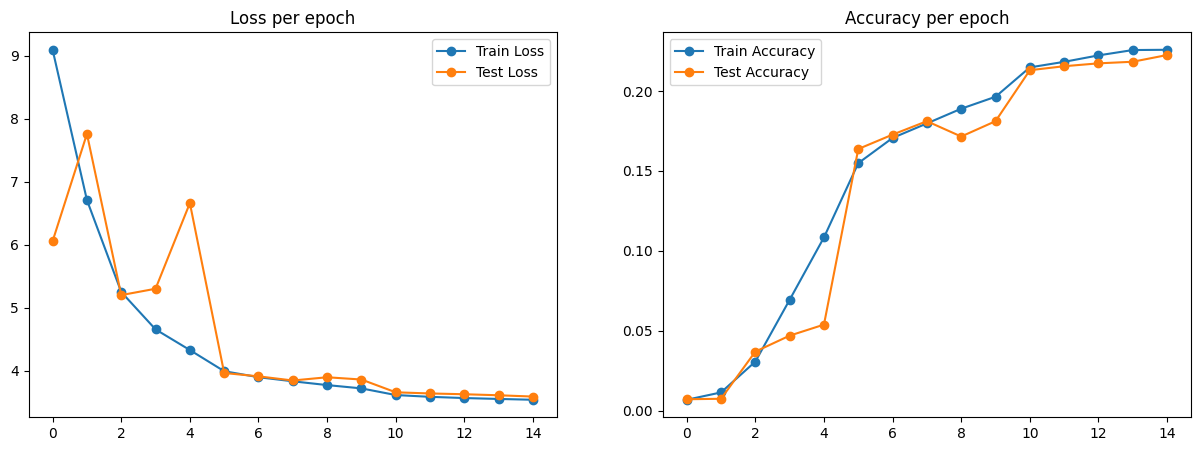

Saving best model

 		 ------------------------------ EPOCH: 16 ------------------------------
[04:49:07] Step 20/176: train loss = 3.53397
[04:49:16] Step 40/176: train loss = 3.5149
[04:49:25] Step 60/176: train loss = 3.50327
[04:49:35] Step 80/176: train loss = 3.50218
[04:49:45] Step 100/176: train loss = 3.49981
[04:49:54] Step 120/176: train loss = 3.50867
[04:50:04] Step 140/176: train loss = 3.51363
[04:50:14] Step 160/176: train loss = 3.51591
Train loss = 3.51624, accuracy = 0.22994, lr: 0.00032
VALIDATION LOSS = 3.58753, VALIDATION ACCURACY = 0.2233
LR: [0.00032]


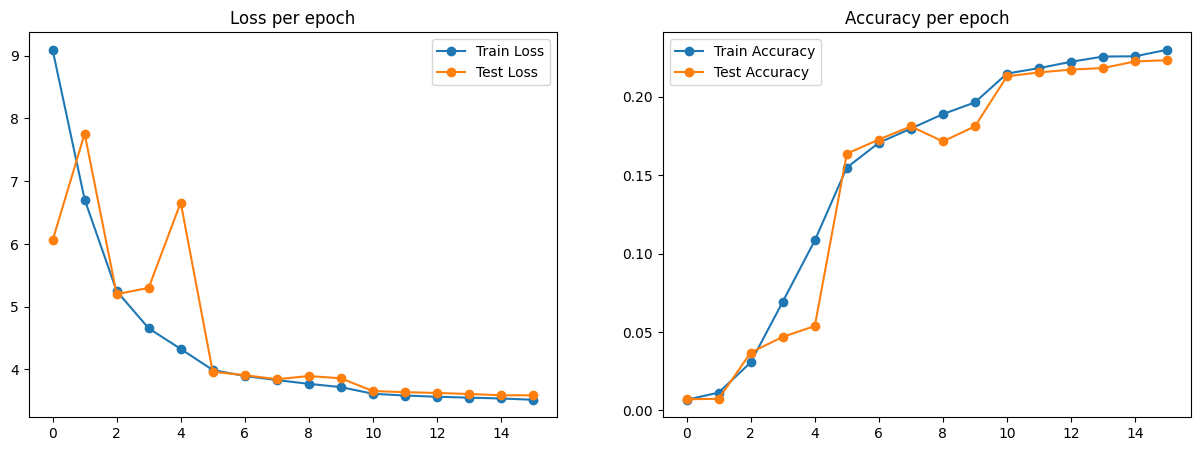

Saving best model

 		 ------------------------------ EPOCH: 17 ------------------------------
[04:50:34] Step 20/176: train loss = 3.49474
[04:50:43] Step 40/176: train loss = 3.49158
[04:50:53] Step 60/176: train loss = 3.49188
[04:51:03] Step 80/176: train loss = 3.50233
[04:51:12] Step 100/176: train loss = 3.50149
[04:51:22] Step 120/176: train loss = 3.50199
[04:51:31] Step 140/176: train loss = 3.5031
[04:51:41] Step 160/176: train loss = 3.50517
Train loss = 3.50481, accuracy = 0.23169, lr: 0.00032
VALIDATION LOSS = 3.58741, VALIDATION ACCURACY = 0.2261
LR: [0.00032]


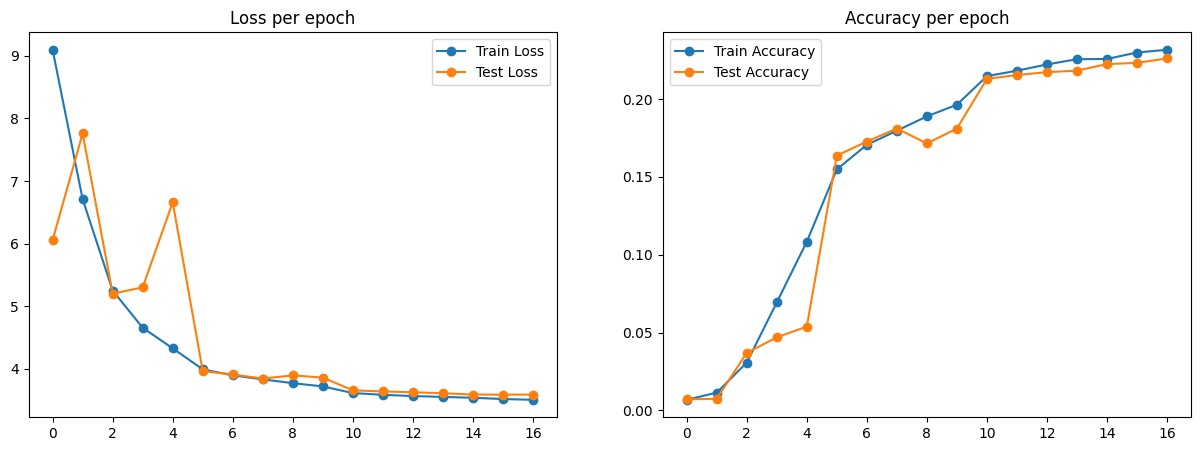

Saving best model

 		 ------------------------------ EPOCH: 18 ------------------------------
[04:52:02] Step 20/176: train loss = 3.46345
[04:52:11] Step 40/176: train loss = 3.46523
[04:52:21] Step 60/176: train loss = 3.47736
[04:52:31] Step 80/176: train loss = 3.4752
[04:52:40] Step 100/176: train loss = 3.47725
[04:52:50] Step 120/176: train loss = 3.47772
[04:52:59] Step 140/176: train loss = 3.47612
[04:53:09] Step 160/176: train loss = 3.48122
Train loss = 3.48353, accuracy = 0.23516, lr: 0.00032
VALIDATION LOSS = 3.54766, VALIDATION ACCURACY = 0.2258
LR: [0.00032]


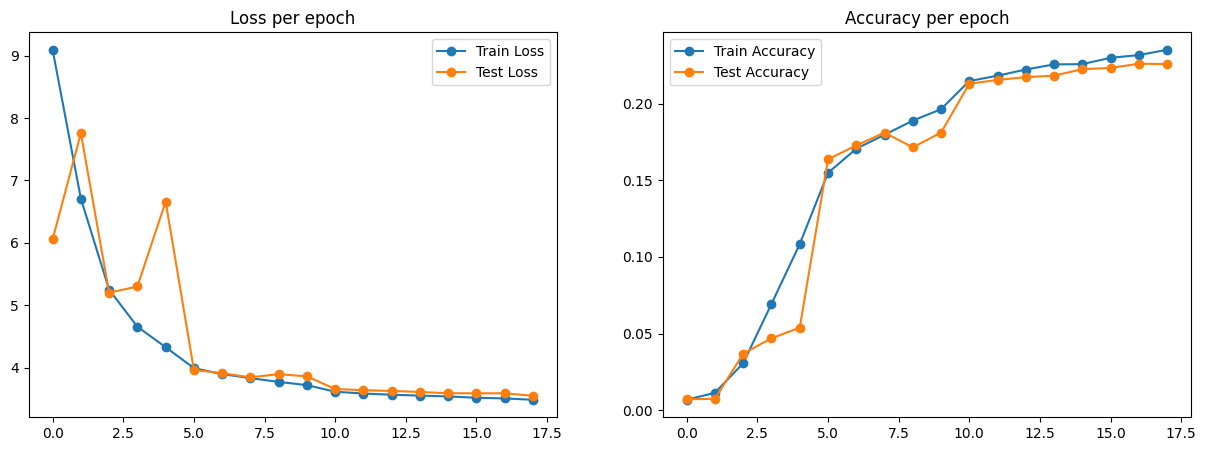

Saving best model

 		 ------------------------------ EPOCH: 19 ------------------------------
[04:53:28] Step 20/176: train loss = 3.46072
[04:53:37] Step 40/176: train loss = 3.47359
[04:53:47] Step 60/176: train loss = 3.47923
[04:53:56] Step 80/176: train loss = 3.47292
[04:54:06] Step 100/176: train loss = 3.47005
[04:54:16] Step 120/176: train loss = 3.46454
[04:54:25] Step 140/176: train loss = 3.46248
[04:54:34] Step 160/176: train loss = 3.46479
Train loss = 3.46689, accuracy = 0.23921, lr: 0.00032
VALIDATION LOSS = 3.56598, VALIDATION ACCURACY = 0.227
LR: [0.00032]


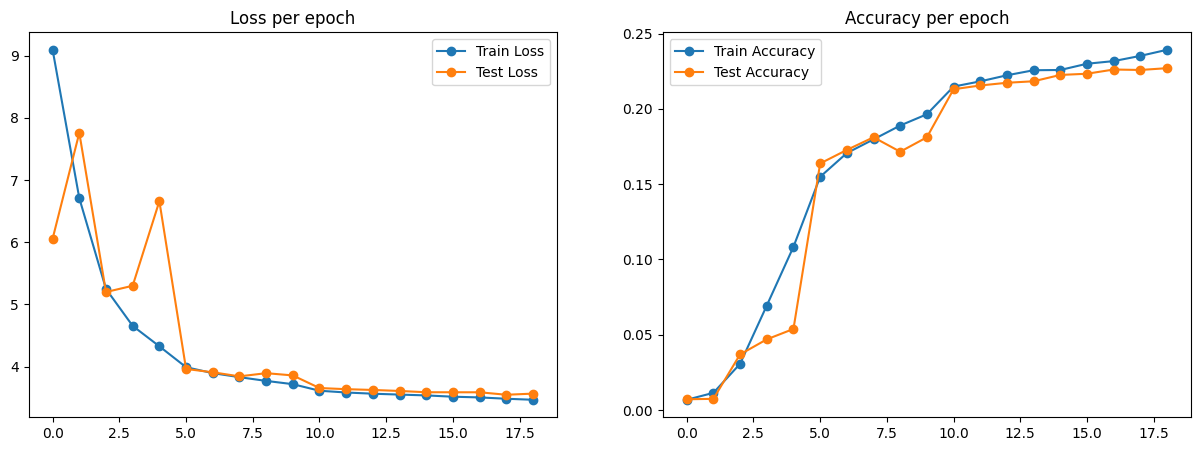

Validation loss didn't improve

 		 ------------------------------ EPOCH: 20 ------------------------------
[04:54:53] Step 20/176: train loss = 3.42671
[04:55:02] Step 40/176: train loss = 3.44597
[04:55:11] Step 60/176: train loss = 3.44799
[04:55:20] Step 80/176: train loss = 3.44249
[04:55:29] Step 100/176: train loss = 3.45069
[04:55:38] Step 120/176: train loss = 3.45092
[04:55:47] Step 140/176: train loss = 3.45315
[04:55:56] Step 160/176: train loss = 3.45909
Train loss = 3.45904, accuracy = 0.23849, lr: 0.00032
VALIDATION LOSS = 3.52641, VALIDATION ACCURACY = 0.2355
LR: [0.00032]


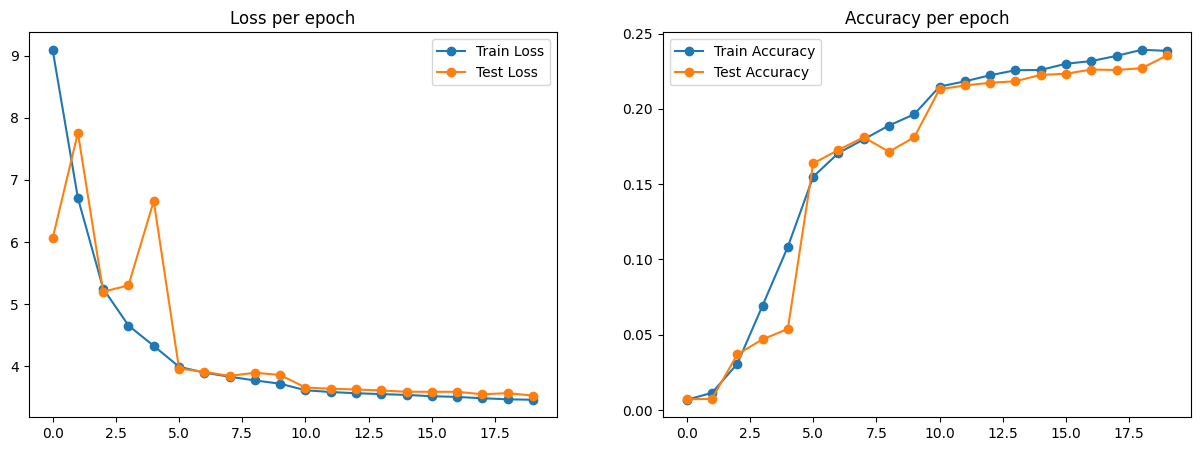

Saving best model

 		 ------------------------------ EPOCH: 21 ------------------------------
[04:56:15] Step 20/176: train loss = 3.40586
[04:56:25] Step 40/176: train loss = 3.41409
[04:56:34] Step 60/176: train loss = 3.41679
[04:56:43] Step 80/176: train loss = 3.42814
[04:56:52] Step 100/176: train loss = 3.43085
[04:57:01] Step 120/176: train loss = 3.43253
[04:57:10] Step 140/176: train loss = 3.43465
[04:57:20] Step 160/176: train loss = 3.43556
Train loss = 3.43704, accuracy = 0.24289, lr: 0.00032
VALIDATION LOSS = 3.51712, VALIDATION ACCURACY = 0.2346
LR: [0.00032]


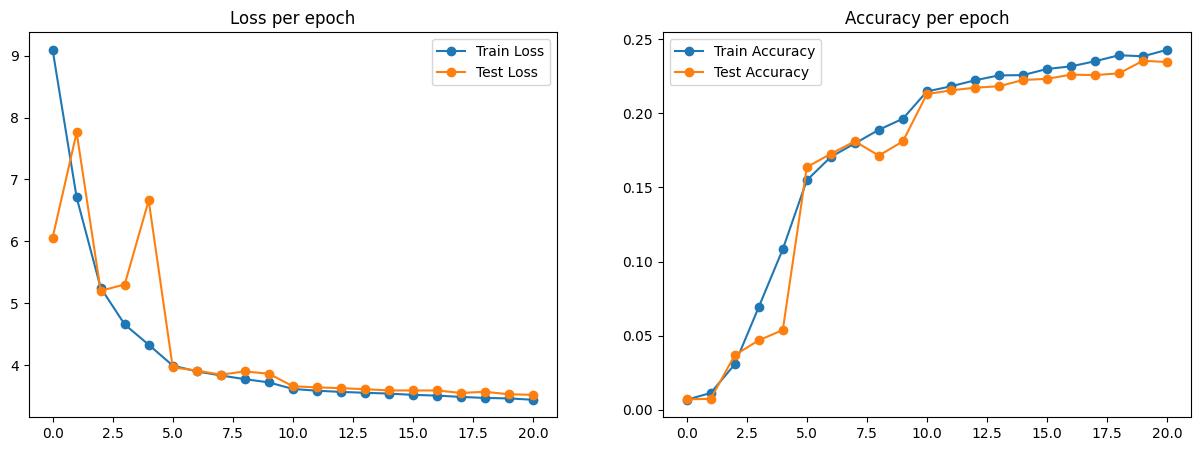

Saving best model

 		 ------------------------------ EPOCH: 22 ------------------------------
[04:57:40] Step 20/176: train loss = 3.40974
[04:57:50] Step 40/176: train loss = 3.40182
[04:58:00] Step 60/176: train loss = 3.41538
[04:58:09] Step 80/176: train loss = 3.42107
[04:58:19] Step 100/176: train loss = 3.41799
[04:58:29] Step 120/176: train loss = 3.41949
[04:58:38] Step 140/176: train loss = 3.41964
[04:58:48] Step 160/176: train loss = 3.4214
Train loss = 3.42025, accuracy = 0.24467, lr: 0.00032
VALIDATION LOSS = 3.49792, VALIDATION ACCURACY = 0.2379
LR: [0.00032]


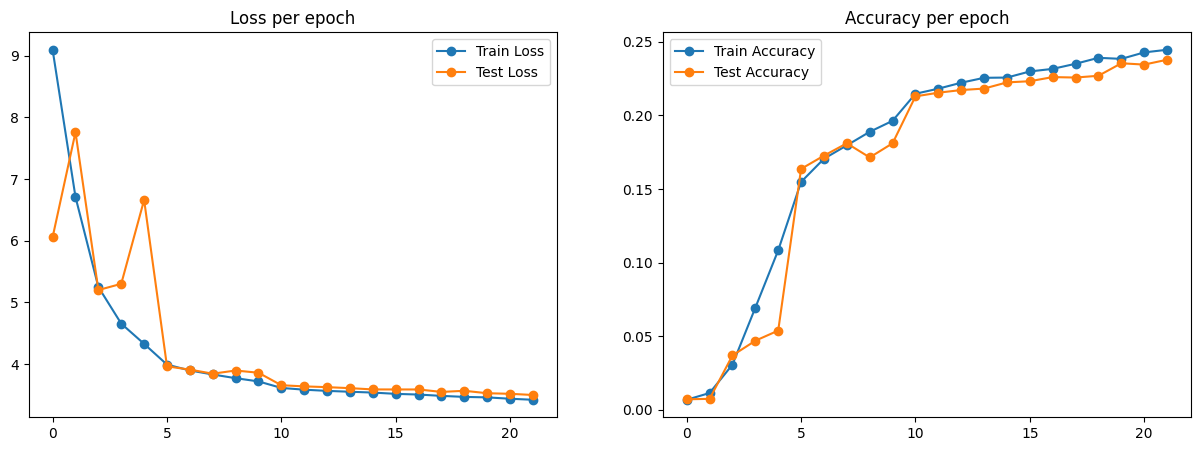

Saving best model

 		 ------------------------------ EPOCH: 23 ------------------------------
[04:59:07] Step 20/176: train loss = 3.41263
[04:59:17] Step 40/176: train loss = 3.40337
[04:59:26] Step 60/176: train loss = 3.40135
[04:59:36] Step 80/176: train loss = 3.40553
[04:59:45] Step 100/176: train loss = 3.40871
[04:59:54] Step 120/176: train loss = 3.40856
[05:00:05] Step 140/176: train loss = 3.40515
[05:00:15] Step 160/176: train loss = 3.40744
Train loss = 3.40611, accuracy = 0.24843, lr: 0.00032
VALIDATION LOSS = 3.50435, VALIDATION ACCURACY = 0.2364
LR: [0.00032]


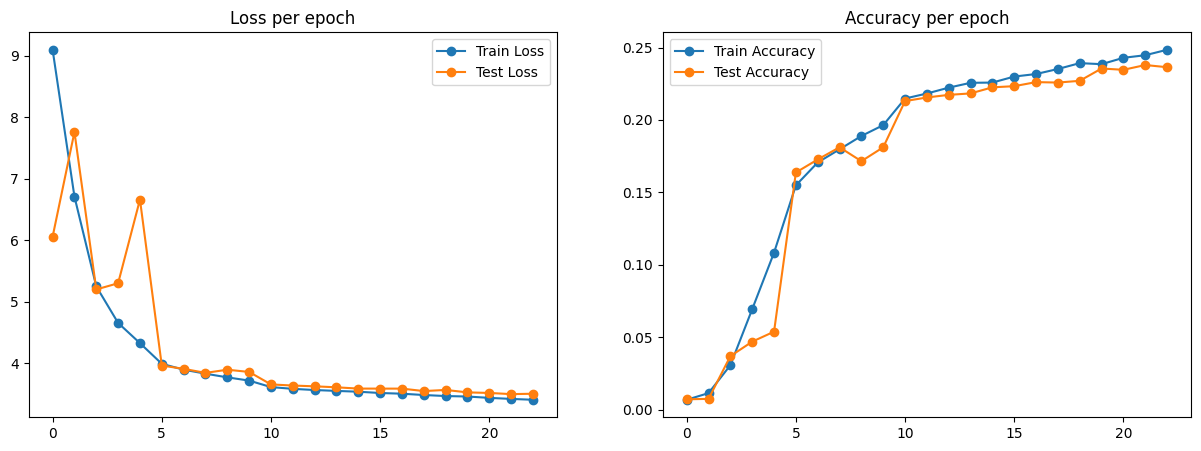

Validation loss didn't improve

 		 ------------------------------ EPOCH: 24 ------------------------------
[05:00:34] Step 20/176: train loss = 3.38337
[05:00:44] Step 40/176: train loss = 3.3828
[05:00:55] Step 60/176: train loss = 3.38385
[05:01:04] Step 80/176: train loss = 3.39083
[05:01:14] Step 100/176: train loss = 3.3881
[05:01:23] Step 120/176: train loss = 3.38708
[05:01:33] Step 140/176: train loss = 3.38371
[05:01:42] Step 160/176: train loss = 3.38714
Train loss = 3.38781, accuracy = 0.24957, lr: 0.00032
VALIDATION LOSS = 3.47232, VALIDATION ACCURACY = 0.2417
LR: [0.00032]


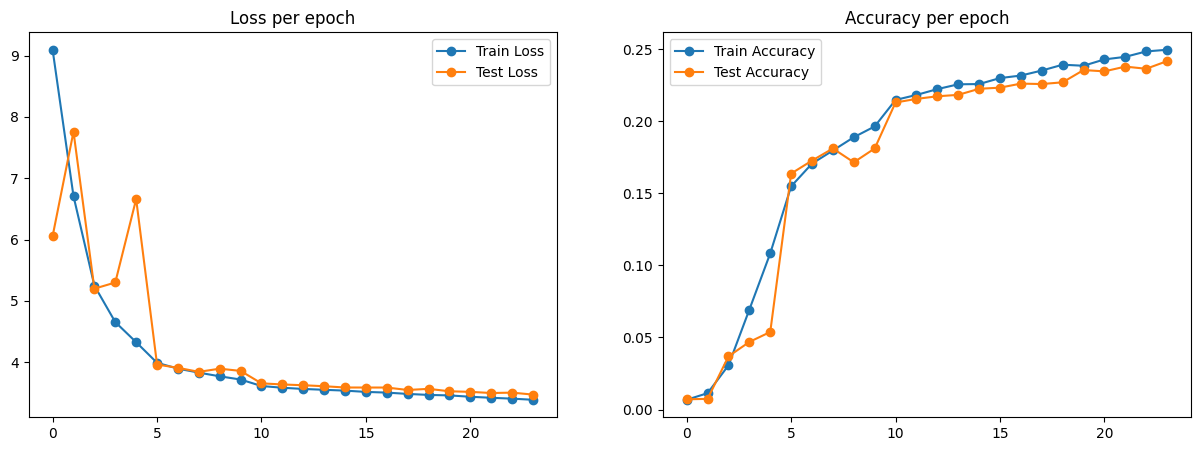

Saving best model

 		 ------------------------------ EPOCH: 25 ------------------------------
[05:02:00] Step 20/176: train loss = 3.38636
[05:02:09] Step 40/176: train loss = 3.35702
[05:02:19] Step 60/176: train loss = 3.3665
[05:02:29] Step 80/176: train loss = 3.3679
[05:02:38] Step 100/176: train loss = 3.35986
[05:02:47] Step 120/176: train loss = 3.35885
[05:02:56] Step 140/176: train loss = 3.36502
[05:03:05] Step 160/176: train loss = 3.3678
Train loss = 3.36948, accuracy = 0.25458, lr: 0.00032
VALIDATION LOSS = 3.46252, VALIDATION ACCURACY = 0.2411
LR: [0.00032]


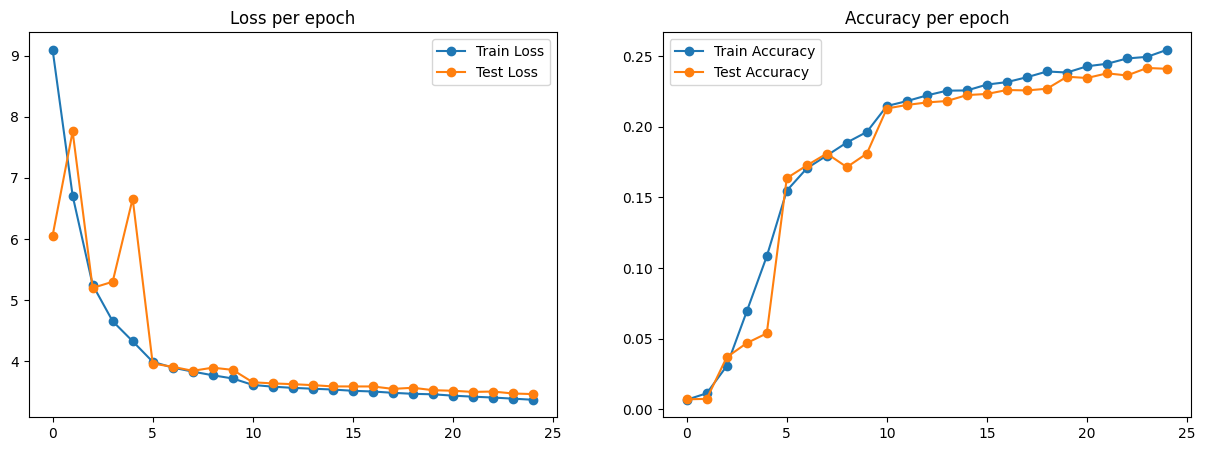

Saving best model

 		 ------------------------------ EPOCH: 26 ------------------------------
[05:03:24] Step 20/176: train loss = 3.34181
[05:03:33] Step 40/176: train loss = 3.33298
[05:03:43] Step 60/176: train loss = 3.33318
[05:03:52] Step 80/176: train loss = 3.34345
[05:04:02] Step 100/176: train loss = 3.3407
[05:04:11] Step 120/176: train loss = 3.34182
[05:04:21] Step 140/176: train loss = 3.3459
[05:04:31] Step 160/176: train loss = 3.35053
Train loss = 3.35041, accuracy = 0.25657, lr: 0.00032
VALIDATION LOSS = 3.45717, VALIDATION ACCURACY = 0.2419
LR: [0.00032]


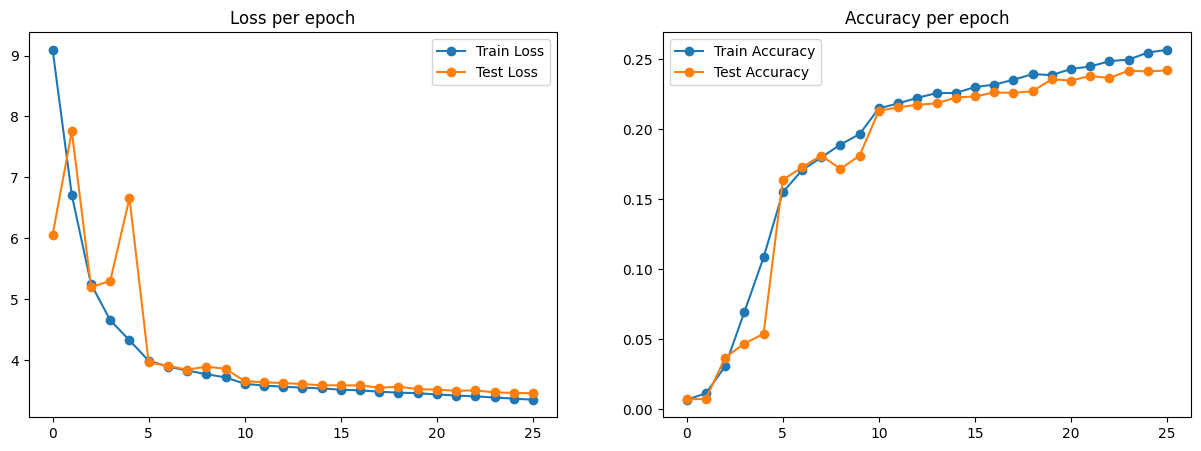

Saving best model

 		 ------------------------------ EPOCH: 27 ------------------------------
[05:04:51] Step 20/176: train loss = 3.33305
[05:05:00] Step 40/176: train loss = 3.33234
[05:05:10] Step 60/176: train loss = 3.33282
[05:05:20] Step 80/176: train loss = 3.32338
[05:05:29] Step 100/176: train loss = 3.32505
[05:05:39] Step 120/176: train loss = 3.33172
[05:05:48] Step 140/176: train loss = 3.3326
[05:05:59] Step 160/176: train loss = 3.33411
Train loss = 3.33656, accuracy = 0.25802, lr: 0.00032
VALIDATION LOSS = 3.44876, VALIDATION ACCURACY = 0.2441
LR: [0.00032]


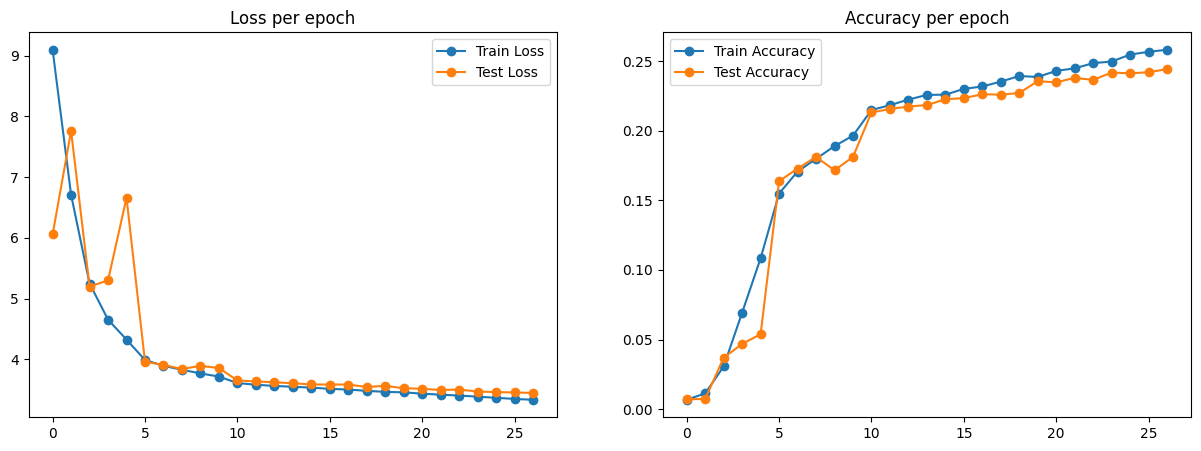

Saving best model

 		 ------------------------------ EPOCH: 28 ------------------------------
[05:06:18] Step 20/176: train loss = 3.31567
[05:06:28] Step 40/176: train loss = 3.31522
[05:06:37] Step 60/176: train loss = 3.30843
[05:06:46] Step 80/176: train loss = 3.30434
[05:06:55] Step 100/176: train loss = 3.3088
[05:07:05] Step 120/176: train loss = 3.30977
[05:07:14] Step 140/176: train loss = 3.31216
[05:07:23] Step 160/176: train loss = 3.31357
Train loss = 3.31612, accuracy = 0.26098, lr: 0.00032
VALIDATION LOSS = 3.41962, VALIDATION ACCURACY = 0.2478
LR: [0.00032]


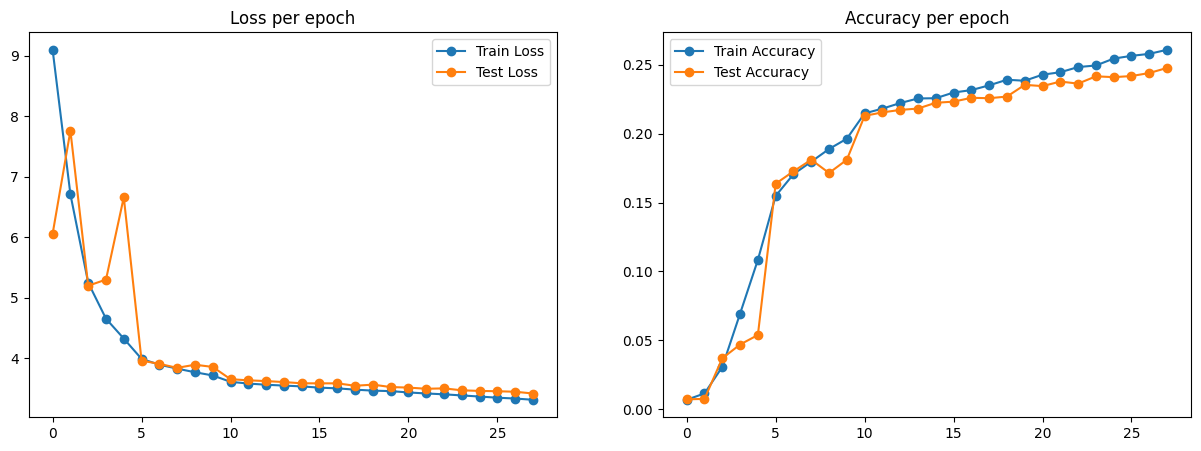

Saving best model

 		 ------------------------------ EPOCH: 29 ------------------------------
[05:07:43] Step 20/176: train loss = 3.30824
[05:07:54] Step 40/176: train loss = 3.30632
[05:08:03] Step 60/176: train loss = 3.31076
[05:08:13] Step 80/176: train loss = 3.30439
[05:08:22] Step 100/176: train loss = 3.30513
[05:08:32] Step 120/176: train loss = 3.30268
[05:08:41] Step 140/176: train loss = 3.29953
[05:08:51] Step 160/176: train loss = 3.29855
Train loss = 3.30176, accuracy = 0.26336, lr: 0.00032
VALIDATION LOSS = 3.40767, VALIDATION ACCURACY = 0.2486
LR: [0.00032]


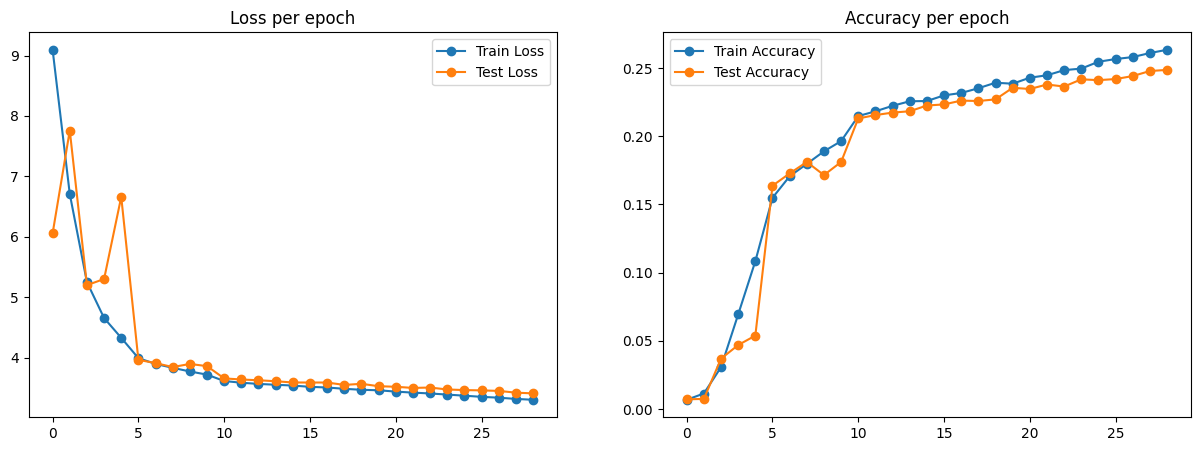

Saving best model

 		 ------------------------------ EPOCH: 30 ------------------------------
[05:09:11] Step 20/176: train loss = 3.23377
[05:09:21] Step 40/176: train loss = 3.25826
[05:09:30] Step 60/176: train loss = 3.2727
[05:09:40] Step 80/176: train loss = 3.28297
[05:09:50] Step 100/176: train loss = 3.27896
[05:09:59] Step 120/176: train loss = 3.27331
[05:10:08] Step 140/176: train loss = 3.28105
[05:10:17] Step 160/176: train loss = 3.28024
Train loss = 3.28271, accuracy = 0.26793, lr: 0.00032
VALIDATION LOSS = 3.40397, VALIDATION ACCURACY = 0.2549
LR: [0.00032]


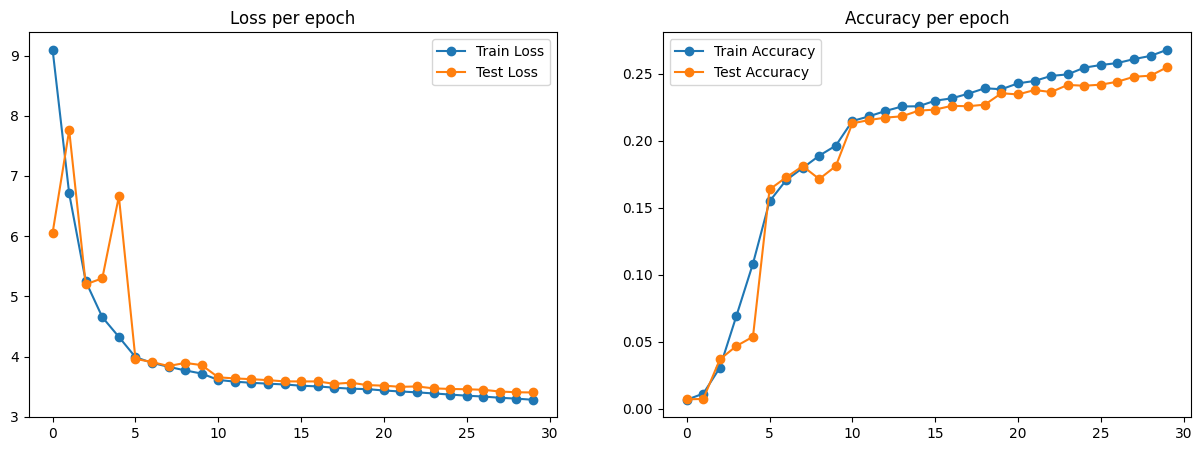

Saving best model

 		 ------------------------------ EPOCH: 31 ------------------------------
[05:10:36] Step 20/176: train loss = 3.26894
[05:10:45] Step 40/176: train loss = 3.26932
[05:10:55] Step 60/176: train loss = 3.26737
[05:11:04] Step 80/176: train loss = 3.26924
[05:11:15] Step 100/176: train loss = 3.26492
[05:11:24] Step 120/176: train loss = 3.26016
[05:11:35] Step 140/176: train loss = 3.25868
[05:11:44] Step 160/176: train loss = 3.26809
Train loss = 3.27119, accuracy = 0.26866, lr: 0.00032
VALIDATION LOSS = 3.40438, VALIDATION ACCURACY = 0.2525
LR: [0.00032]


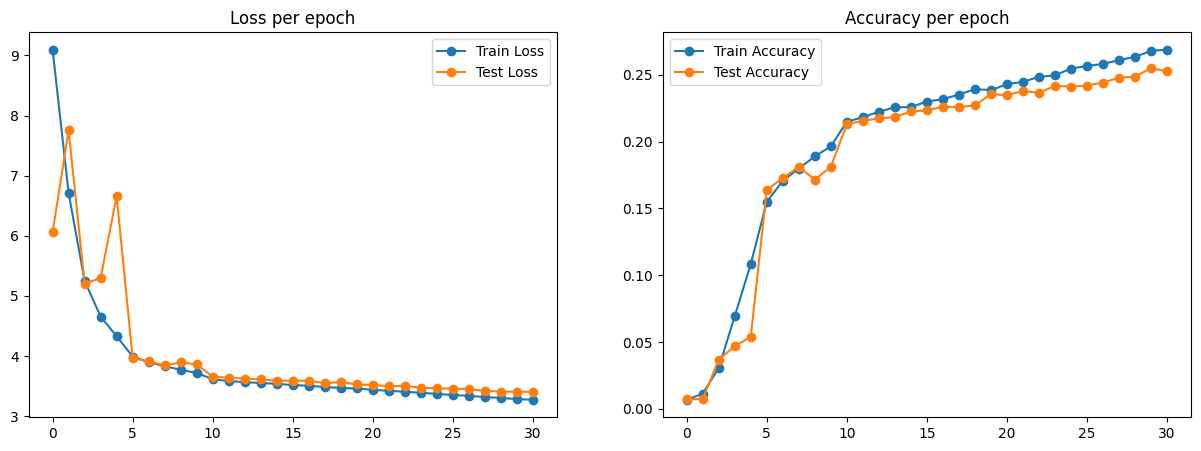

Validation loss didn't improve

 		 ------------------------------ EPOCH: 32 ------------------------------
[05:12:04] Step 20/176: train loss = 3.23631
[05:12:13] Step 40/176: train loss = 3.26284
[05:12:23] Step 60/176: train loss = 3.25155
[05:12:32] Step 80/176: train loss = 3.25653
[05:12:42] Step 100/176: train loss = 3.25787
[05:12:52] Step 120/176: train loss = 3.25882
[05:13:01] Step 140/176: train loss = 3.2561
[05:13:11] Step 160/176: train loss = 3.25338
Train loss = 3.2523, accuracy = 0.27378, lr: 0.00032
VALIDATION LOSS = 3.40204, VALIDATION ACCURACY = 0.2555
LR: [0.00032]


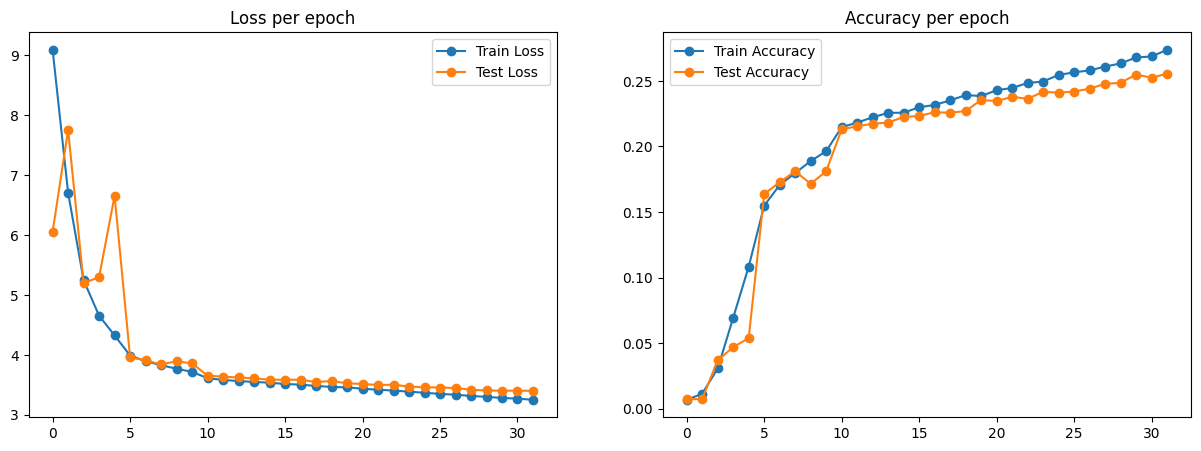

Saving best model

 		 ------------------------------ EPOCH: 33 ------------------------------
[05:13:32] Step 20/176: train loss = 3.20981
[05:13:41] Step 40/176: train loss = 3.22352
[05:13:50] Step 60/176: train loss = 3.22346
[05:13:59] Step 80/176: train loss = 3.22753
[05:14:08] Step 100/176: train loss = 3.23259
[05:14:18] Step 120/176: train loss = 3.23346
[05:14:27] Step 140/176: train loss = 3.23631
[05:14:37] Step 160/176: train loss = 3.23266
Train loss = 3.23293, accuracy = 0.27649, lr: 0.00032
VALIDATION LOSS = 3.36769, VALIDATION ACCURACY = 0.2597
LR: [0.00032]


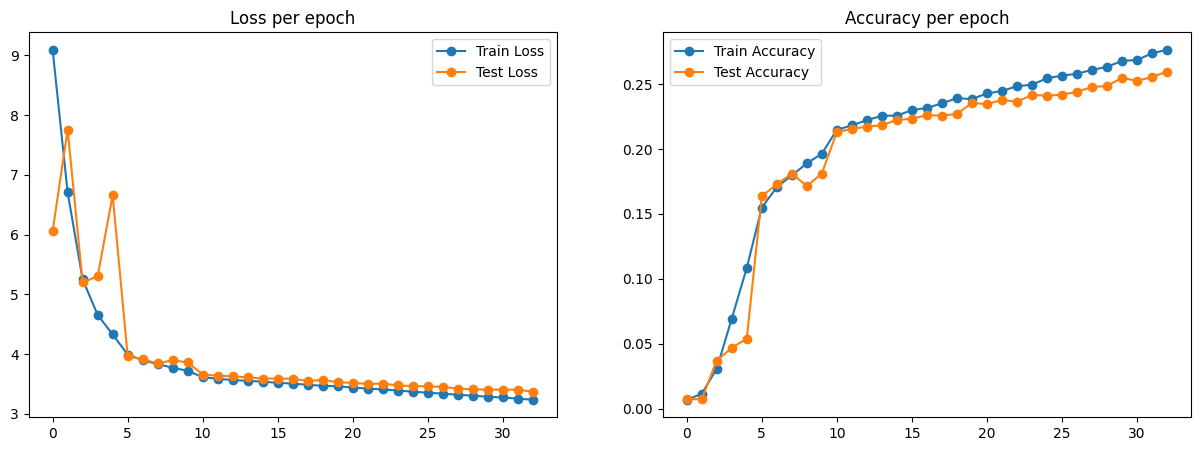

Saving best model

 		 ------------------------------ EPOCH: 34 ------------------------------
[05:14:57] Step 20/176: train loss = 3.18138
[05:15:06] Step 40/176: train loss = 3.1904
[05:15:16] Step 60/176: train loss = 3.20031
[05:15:24] Step 80/176: train loss = 3.20703
[05:15:33] Step 100/176: train loss = 3.2058
[05:15:43] Step 120/176: train loss = 3.20761
[05:15:52] Step 140/176: train loss = 3.21701
[05:16:01] Step 160/176: train loss = 3.21824
Train loss = 3.22341, accuracy = 0.27937, lr: 0.00032
VALIDATION LOSS = 3.3895, VALIDATION ACCURACY = 0.2589
LR: [0.00032]


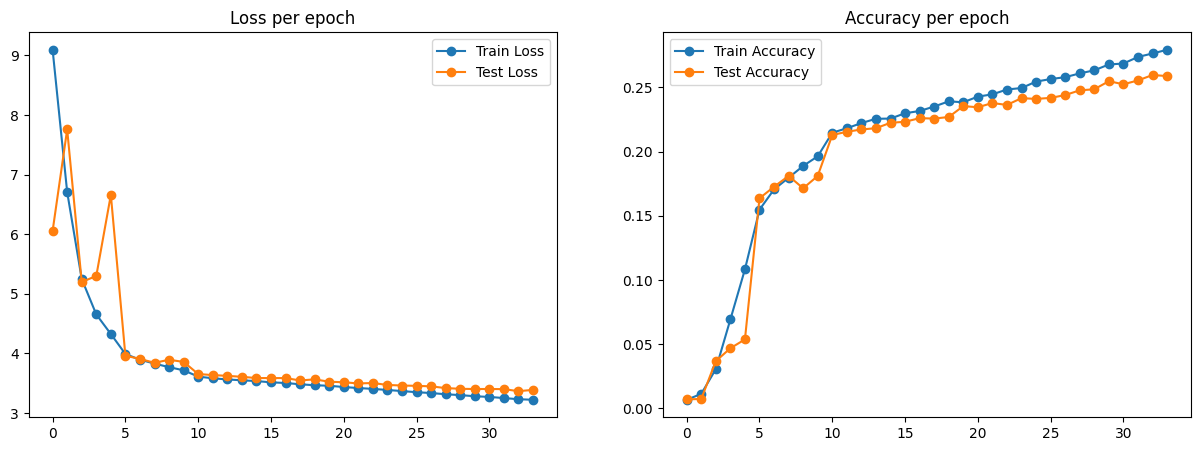

Validation loss didn't improve

 		 ------------------------------ EPOCH: 35 ------------------------------
[05:16:21] Step 20/176: train loss = 3.1661
[05:16:31] Step 40/176: train loss = 3.17793
[05:16:41] Step 60/176: train loss = 3.19215
[05:16:51] Step 80/176: train loss = 3.19093
[05:17:00] Step 100/176: train loss = 3.19943
[05:17:10] Step 120/176: train loss = 3.20446
[05:17:19] Step 140/176: train loss = 3.20603
[05:17:29] Step 160/176: train loss = 3.20238
Train loss = 3.20569, accuracy = 0.28106, lr: 0.00032
VALIDATION LOSS = 3.37143, VALIDATION ACCURACY = 0.261
LR: [0.0001]


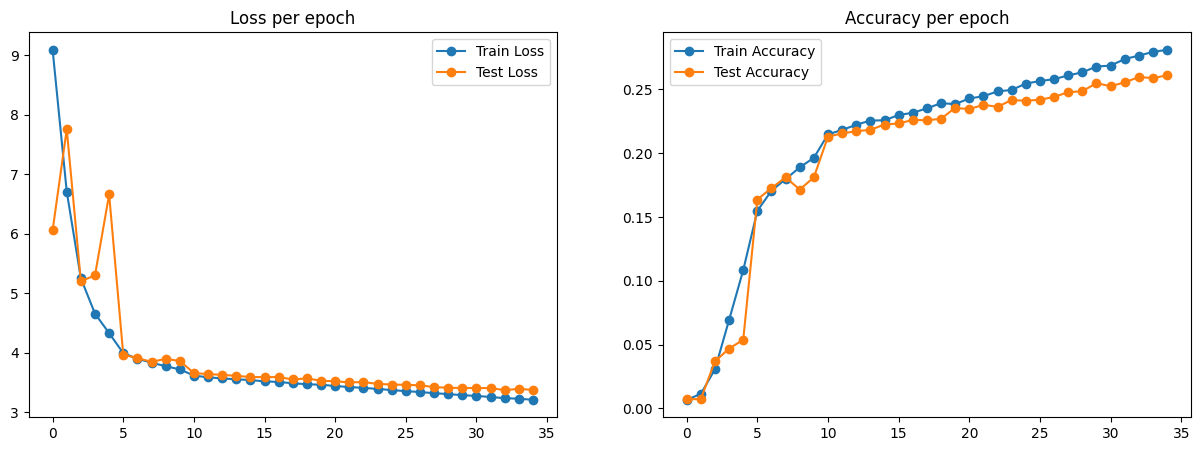

Validation loss didn't improve

 		 ------------------------------ EPOCH: 36 ------------------------------
[05:17:50] Step 20/176: train loss = 3.19274
[05:17:59] Step 40/176: train loss = 3.18219
[05:18:08] Step 60/176: train loss = 3.17822
[05:18:17] Step 80/176: train loss = 3.16589
[05:18:26] Step 100/176: train loss = 3.16279
[05:18:35] Step 120/176: train loss = 3.15822
[05:18:44] Step 140/176: train loss = 3.16015
[05:18:53] Step 160/176: train loss = 3.15984
Train loss = 3.15892, accuracy = 0.28937, lr: 0.0001
VALIDATION LOSS = 3.30783, VALIDATION ACCURACY = 0.2684
LR: [0.0001]


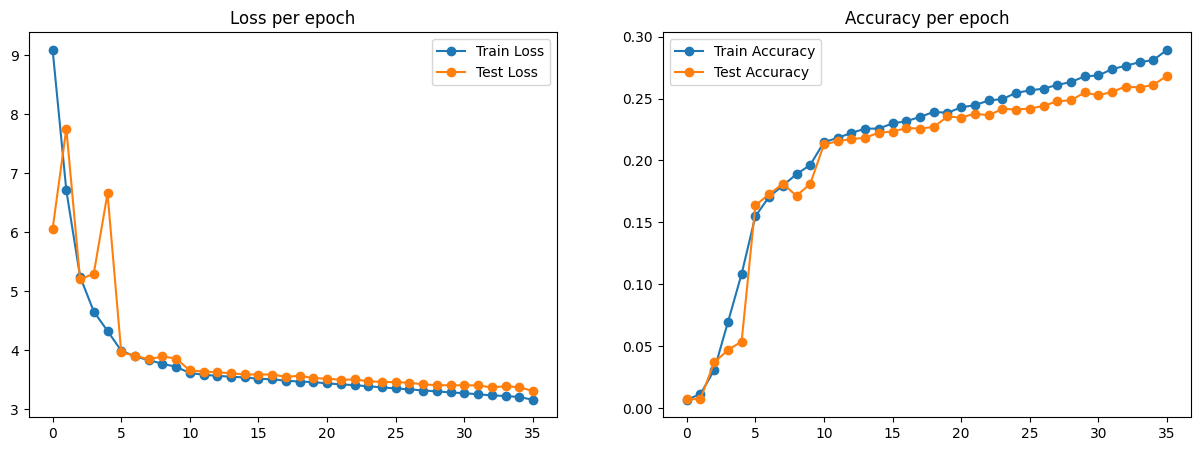

Saving best model

 		 ------------------------------ EPOCH: 37 ------------------------------
[05:19:12] Step 20/176: train loss = 3.14751
[05:19:21] Step 40/176: train loss = 3.14464
[05:19:30] Step 60/176: train loss = 3.14368
[05:19:40] Step 80/176: train loss = 3.14324
[05:19:50] Step 100/176: train loss = 3.14417
[05:20:00] Step 120/176: train loss = 3.14572
[05:20:10] Step 140/176: train loss = 3.14551
[05:20:20] Step 160/176: train loss = 3.14388
Train loss = 3.14234, accuracy = 0.29209, lr: 0.0001
VALIDATION LOSS = 3.29606, VALIDATION ACCURACY = 0.2721
LR: [0.0001]


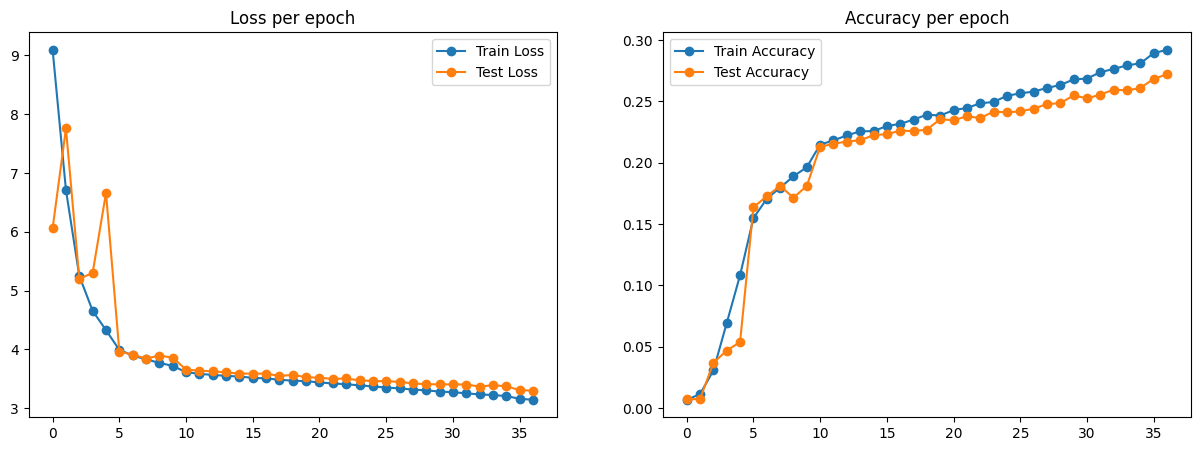

Saving best model

 		 ------------------------------ EPOCH: 38 ------------------------------
[05:20:41] Step 20/176: train loss = 3.14193
[05:20:51] Step 40/176: train loss = 3.13884
[05:21:01] Step 60/176: train loss = 3.14364
[05:21:11] Step 80/176: train loss = 3.13763
[05:21:20] Step 100/176: train loss = 3.14033
[05:21:29] Step 120/176: train loss = 3.14287
[05:21:39] Step 140/176: train loss = 3.14441
[05:21:49] Step 160/176: train loss = 3.13877
Train loss = 3.13666, accuracy = 0.2946, lr: 0.0001
VALIDATION LOSS = 3.30431, VALIDATION ACCURACY = 0.2704
LR: [0.0001]


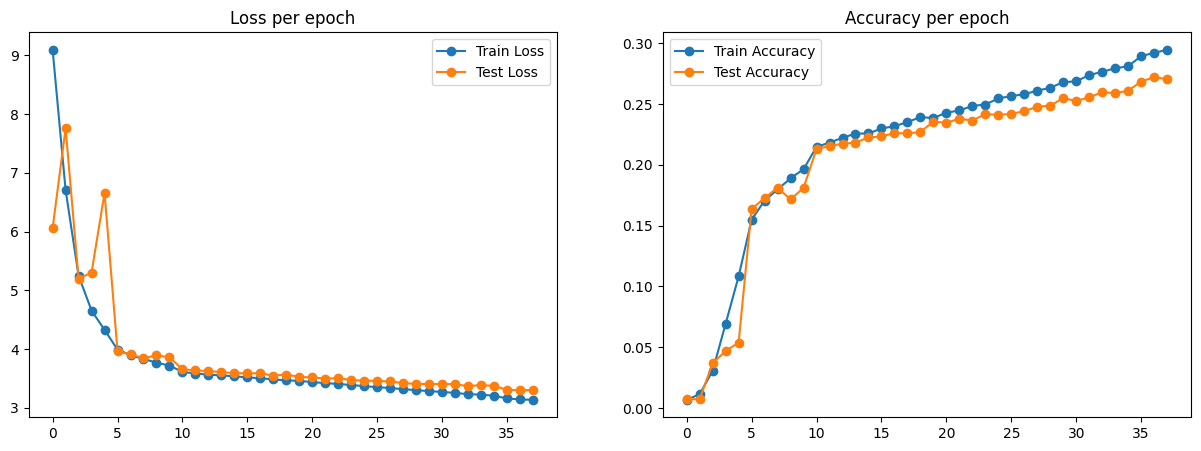

Validation loss didn't improve

 		 ------------------------------ EPOCH: 39 ------------------------------
[05:22:08] Step 20/176: train loss = 3.12498
[05:22:17] Step 40/176: train loss = 3.13961
[05:22:26] Step 60/176: train loss = 3.13879
[05:22:36] Step 80/176: train loss = 3.13984
[05:22:45] Step 100/176: train loss = 3.13567
[05:22:55] Step 120/176: train loss = 3.13643
[05:23:04] Step 140/176: train loss = 3.1322
[05:23:13] Step 160/176: train loss = 3.13263
Train loss = 3.13203, accuracy = 0.29368, lr: 0.0001
VALIDATION LOSS = 3.28368, VALIDATION ACCURACY = 0.2747
LR: [0.0001]


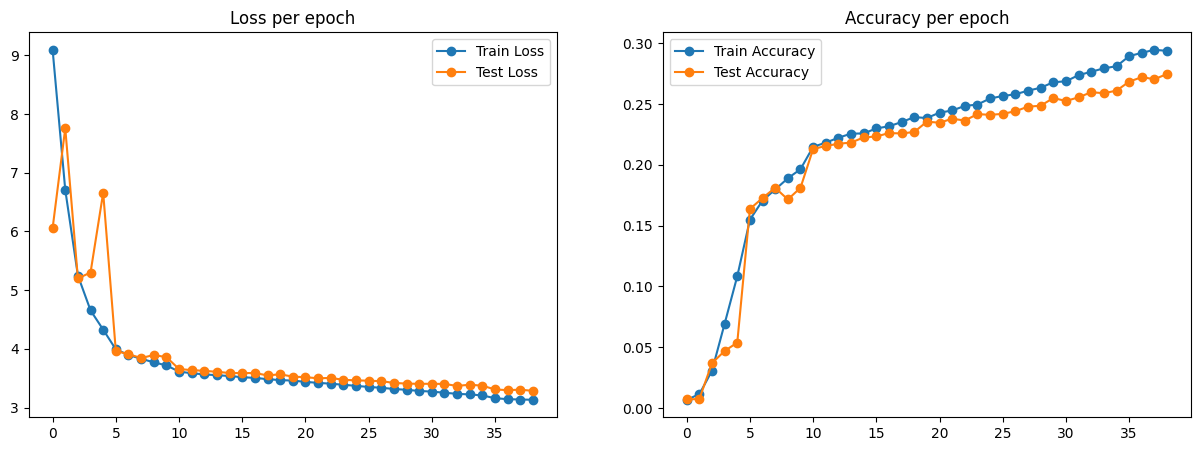

Saving best model

 		 ------------------------------ EPOCH: 40 ------------------------------
[05:23:32] Step 20/176: train loss = 3.1146
[05:23:41] Step 40/176: train loss = 3.12538
[05:23:50] Step 60/176: train loss = 3.12911
[05:23:59] Step 80/176: train loss = 3.12188
[05:24:08] Step 100/176: train loss = 3.13144
[05:24:17] Step 120/176: train loss = 3.1271
[05:24:26] Step 140/176: train loss = 3.12881
[05:24:36] Step 160/176: train loss = 3.12887
Train loss = 3.12728, accuracy = 0.29653, lr: 0.0001
VALIDATION LOSS = 3.29003, VALIDATION ACCURACY = 0.2733
LR: [0.0001]


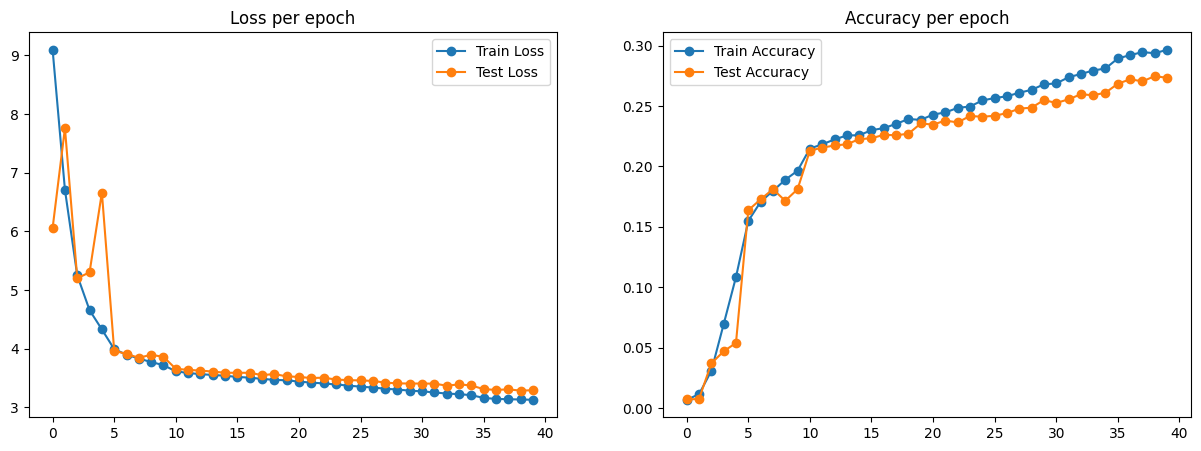

Validation loss didn't improve

 		 ------------------------------ EPOCH: 41 ------------------------------
[05:24:55] Step 20/176: train loss = 3.0806
[05:25:05] Step 40/176: train loss = 3.09611
[05:25:15] Step 60/176: train loss = 3.09903
[05:25:24] Step 80/176: train loss = 3.10288
[05:25:33] Step 100/176: train loss = 3.10883
[05:25:43] Step 120/176: train loss = 3.11001
[05:25:52] Step 140/176: train loss = 3.11772
[05:26:02] Step 160/176: train loss = 3.11769
Train loss = 3.11765, accuracy = 0.29748, lr: 0.0001
VALIDATION LOSS = 3.28182, VALIDATION ACCURACY = 0.2748
LR: [0.0001]


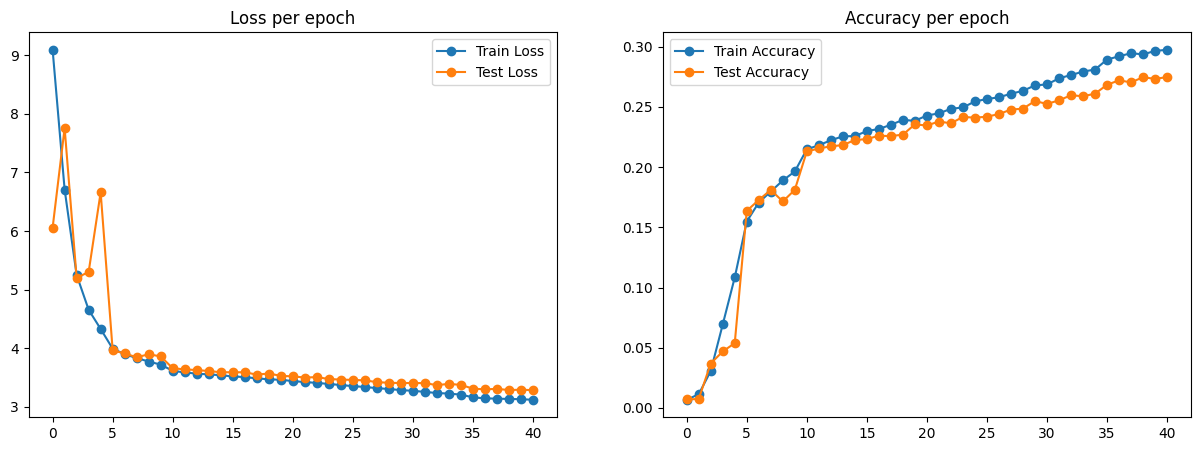

Saving best model

 		 ------------------------------ EPOCH: 42 ------------------------------
[05:26:22] Step 20/176: train loss = 3.07885
[05:26:32] Step 40/176: train loss = 3.08524
[05:26:41] Step 60/176: train loss = 3.09963
[05:26:51] Step 80/176: train loss = 3.10089
[05:27:01] Step 100/176: train loss = 3.10975
[05:27:10] Step 120/176: train loss = 3.11113
[05:27:20] Step 140/176: train loss = 3.11115
[05:27:29] Step 160/176: train loss = 3.11349
Train loss = 3.11449, accuracy = 0.2969, lr: 0.0001
VALIDATION LOSS = 3.27158, VALIDATION ACCURACY = 0.2761
LR: [0.0001]


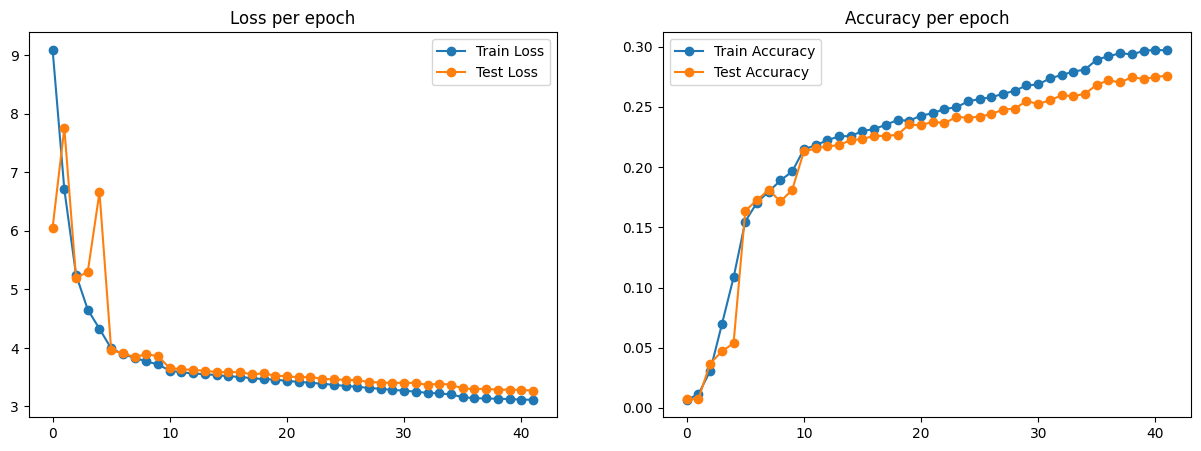

Saving best model

 		 ------------------------------ EPOCH: 43 ------------------------------
[05:27:48] Step 20/176: train loss = 3.09593
[05:27:57] Step 40/176: train loss = 3.09745
[05:28:07] Step 60/176: train loss = 3.09498
[05:28:18] Step 80/176: train loss = 3.09871
[05:28:27] Step 100/176: train loss = 3.09674
[05:28:37] Step 120/176: train loss = 3.10077
[05:28:46] Step 140/176: train loss = 3.10215
[05:28:55] Step 160/176: train loss = 3.10808
Train loss = 3.10642, accuracy = 0.29817, lr: 0.0001
VALIDATION LOSS = 3.26861, VALIDATION ACCURACY = 0.2789
LR: [0.0001]


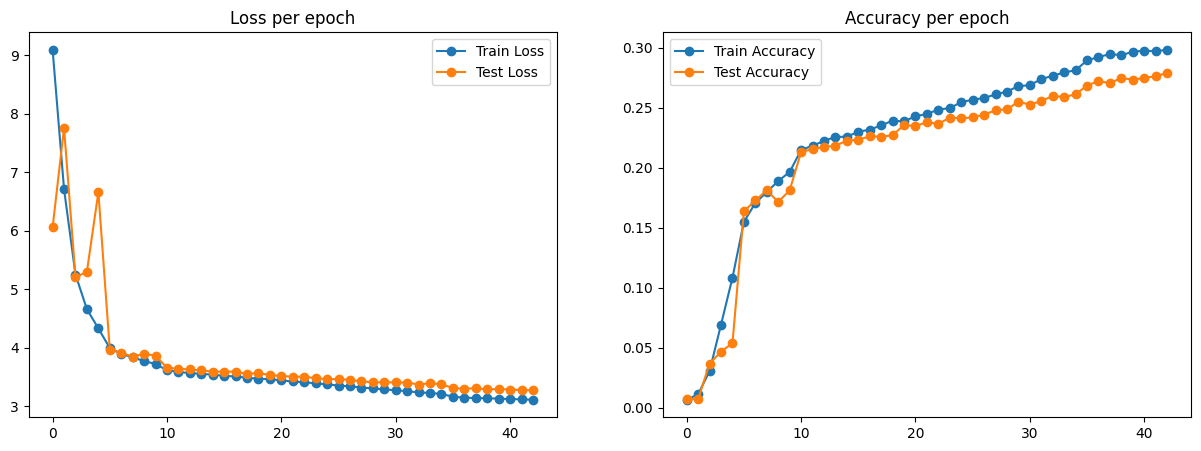

Saving best model

 		 ------------------------------ EPOCH: 44 ------------------------------
[05:29:14] Step 20/176: train loss = 3.11466
[05:29:22] Step 40/176: train loss = 3.12405
[05:29:32] Step 60/176: train loss = 3.11362
[05:29:41] Step 80/176: train loss = 3.11381
[05:29:50] Step 100/176: train loss = 3.10825
[05:29:59] Step 120/176: train loss = 3.10521
[05:30:08] Step 140/176: train loss = 3.10763
[05:30:18] Step 160/176: train loss = 3.11022
Train loss = 3.10743, accuracy = 0.2977, lr: 0.0001
VALIDATION LOSS = 3.27179, VALIDATION ACCURACY = 0.2773
LR: [0.0001]


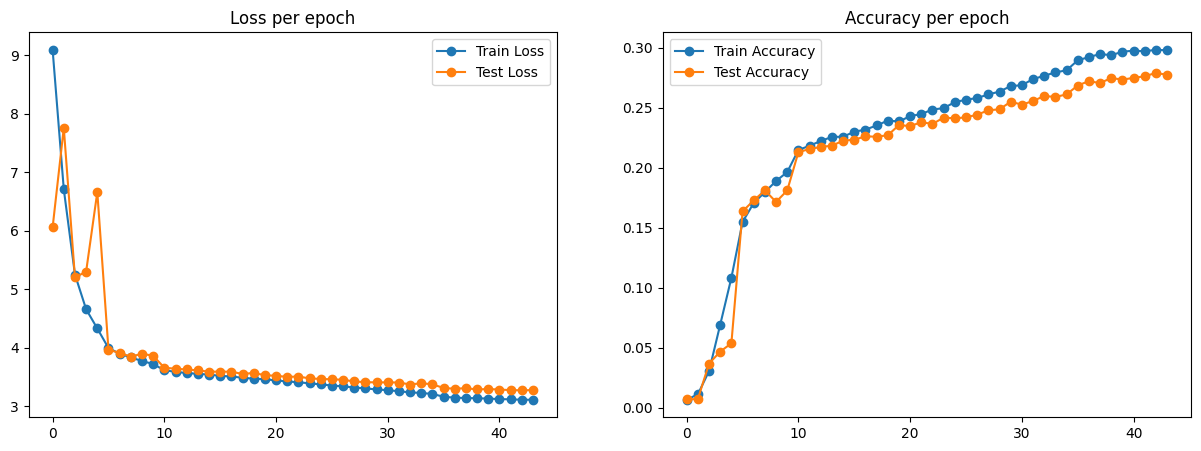

Validation loss didn't improve

 		 ------------------------------ EPOCH: 45 ------------------------------
[05:30:36] Step 20/176: train loss = 3.08768
[05:30:46] Step 40/176: train loss = 3.09956
[05:30:55] Step 60/176: train loss = 3.09819
[05:31:04] Step 80/176: train loss = 3.09521
[05:31:13] Step 100/176: train loss = 3.09458
[05:31:22] Step 120/176: train loss = 3.09172
[05:31:31] Step 140/176: train loss = 3.09315
[05:31:41] Step 160/176: train loss = 3.09379
Train loss = 3.09442, accuracy = 0.30213, lr: 0.0001
VALIDATION LOSS = 3.26148, VALIDATION ACCURACY = 0.2782
LR: [0.0001]


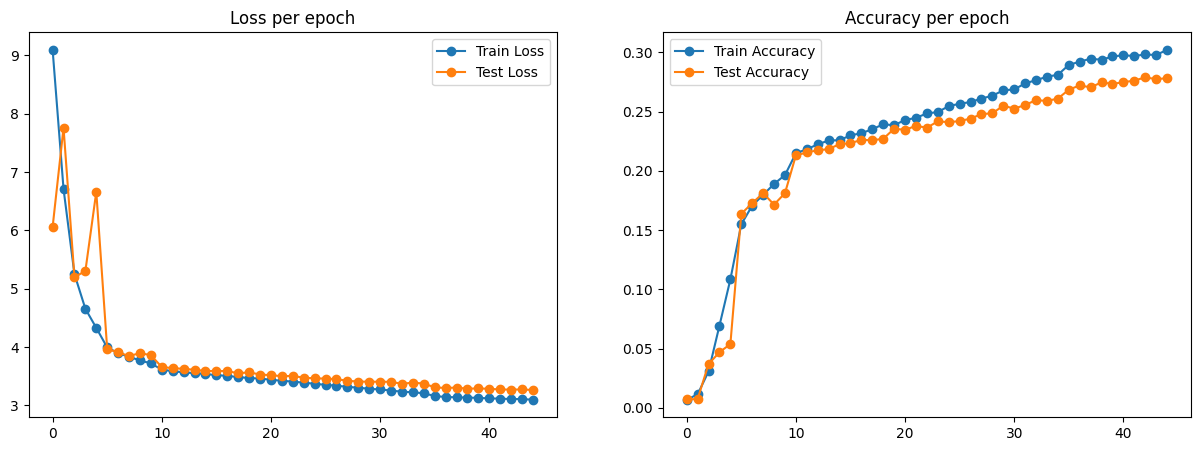

Saving best model

 		 ------------------------------ EPOCH: 46 ------------------------------
[05:32:01] Step 20/176: train loss = 3.08094
[05:32:10] Step 40/176: train loss = 3.0809
[05:32:19] Step 60/176: train loss = 3.07125
[05:32:29] Step 80/176: train loss = 3.08248
[05:32:38] Step 100/176: train loss = 3.0858
[05:32:48] Step 120/176: train loss = 3.09129
[05:32:58] Step 140/176: train loss = 3.08837
[05:33:08] Step 160/176: train loss = 3.0919
Train loss = 3.09118, accuracy = 0.30097, lr: 0.0001
VALIDATION LOSS = 3.25487, VALIDATION ACCURACY = 0.2798
LR: [0.0001]


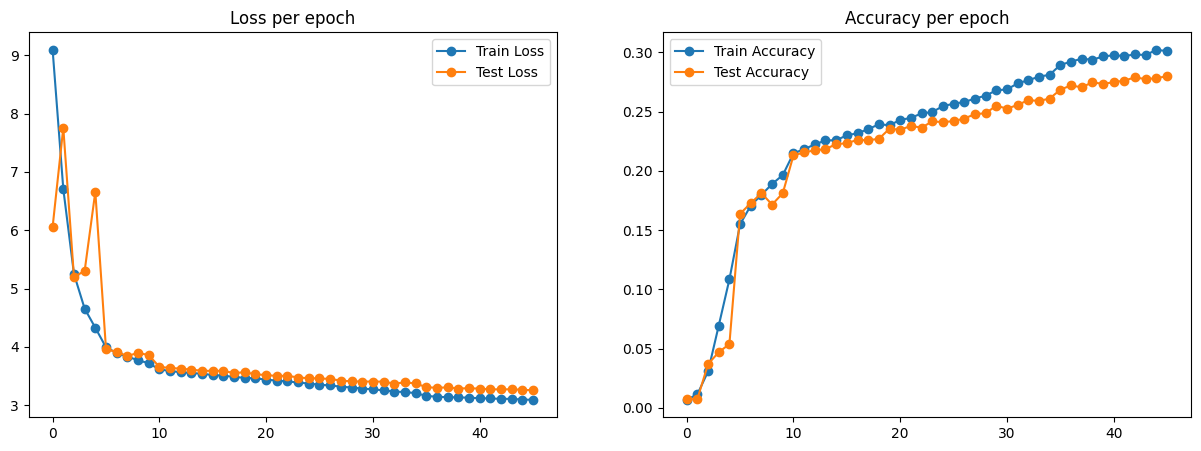

Saving best model

 		 ------------------------------ EPOCH: 47 ------------------------------
[05:33:28] Step 20/176: train loss = 3.10709
[05:33:38] Step 40/176: train loss = 3.09879
[05:33:47] Step 60/176: train loss = 3.0852
[05:33:57] Step 80/176: train loss = 3.0845
[05:34:06] Step 100/176: train loss = 3.08532
[05:34:15] Step 120/176: train loss = 3.08547
[05:34:25] Step 140/176: train loss = 3.08281
[05:34:34] Step 160/176: train loss = 3.07931
Train loss = 3.08498, accuracy = 0.30144, lr: 0.0001
VALIDATION LOSS = 3.25346, VALIDATION ACCURACY = 0.2808
LR: [0.0001]


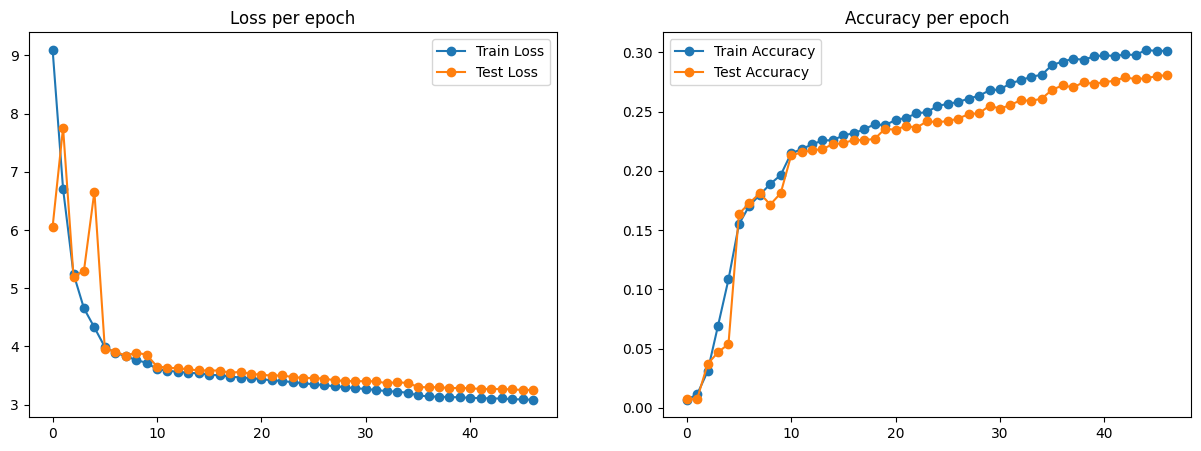

Saving best model

 		 ------------------------------ EPOCH: 48 ------------------------------
[05:34:54] Step 20/176: train loss = 3.09488
[05:35:03] Step 40/176: train loss = 3.09029
[05:35:12] Step 60/176: train loss = 3.08445
[05:35:21] Step 80/176: train loss = 3.08528
[05:35:31] Step 100/176: train loss = 3.07881
[05:35:40] Step 120/176: train loss = 3.0783
[05:35:49] Step 140/176: train loss = 3.08325
[05:35:58] Step 160/176: train loss = 3.07822
Train loss = 3.08007, accuracy = 0.30669, lr: 0.0001
VALIDATION LOSS = 3.23928, VALIDATION ACCURACY = 0.2813
LR: [0.0001]


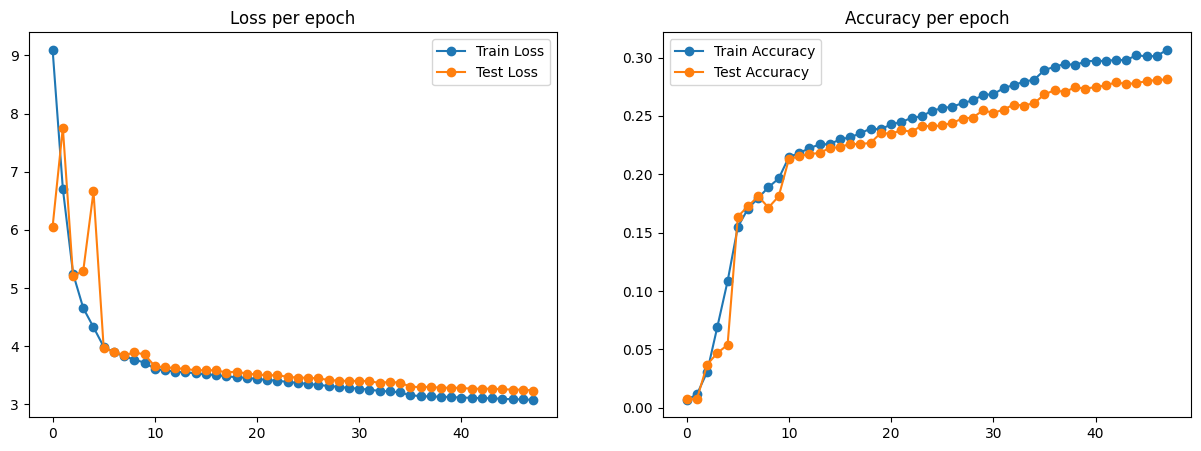

Saving best model

 		 ------------------------------ EPOCH: 49 ------------------------------
[05:36:17] Step 20/176: train loss = 3.06206
[05:36:26] Step 40/176: train loss = 3.0606
[05:36:36] Step 60/176: train loss = 3.05859
[05:36:46] Step 80/176: train loss = 3.05818
[05:36:56] Step 100/176: train loss = 3.06266
[05:37:06] Step 120/176: train loss = 3.0632
[05:37:15] Step 140/176: train loss = 3.06487
[05:37:25] Step 160/176: train loss = 3.06987
Train loss = 3.07268, accuracy = 0.30263, lr: 0.0001
VALIDATION LOSS = 3.24895, VALIDATION ACCURACY = 0.2797
LR: [0.0001]


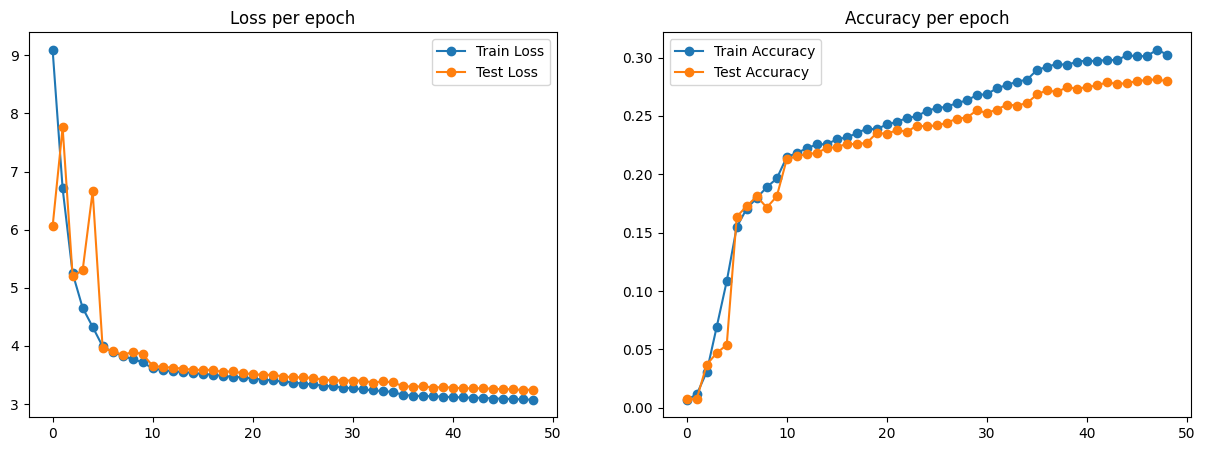

Validation loss didn't improve

 		 ------------------------------ EPOCH: 50 ------------------------------
[05:37:44] Step 20/176: train loss = 3.03966
[05:37:53] Step 40/176: train loss = 3.04739
[05:38:03] Step 60/176: train loss = 3.06143
[05:38:11] Step 80/176: train loss = 3.06783
[05:38:21] Step 100/176: train loss = 3.06485
[05:38:31] Step 120/176: train loss = 3.05961
[05:38:40] Step 140/176: train loss = 3.05893
[05:38:49] Step 160/176: train loss = 3.0598
Train loss = 3.06104, accuracy = 0.30663, lr: 0.0001
VALIDATION LOSS = 3.23527, VALIDATION ACCURACY = 0.2867
LR: [0.0001]


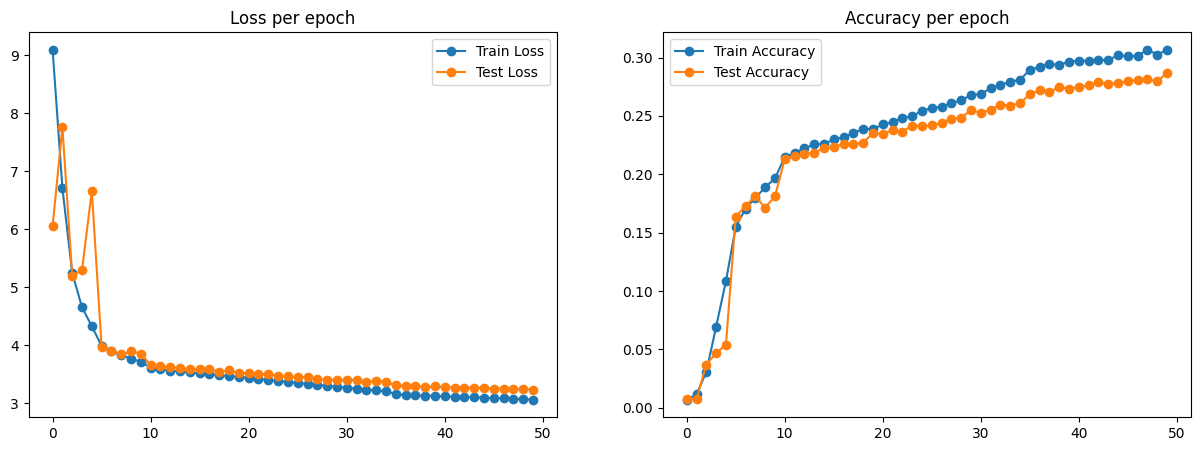

Saving best model

 		 ------------------------------ EPOCH: 51 ------------------------------
[05:39:08] Step 20/176: train loss = 3.05519
[05:39:17] Step 40/176: train loss = 3.05134
[05:39:27] Step 60/176: train loss = 3.04693
[05:39:37] Step 80/176: train loss = 3.04485
[05:39:46] Step 100/176: train loss = 3.05435
[05:39:56] Step 120/176: train loss = 3.05529
[05:40:06] Step 140/176: train loss = 3.05819
[05:40:16] Step 160/176: train loss = 3.05932
Train loss = 3.05922, accuracy = 0.30677, lr: 0.0001
VALIDATION LOSS = 3.22785, VALIDATION ACCURACY = 0.2861
LR: [0.0001]


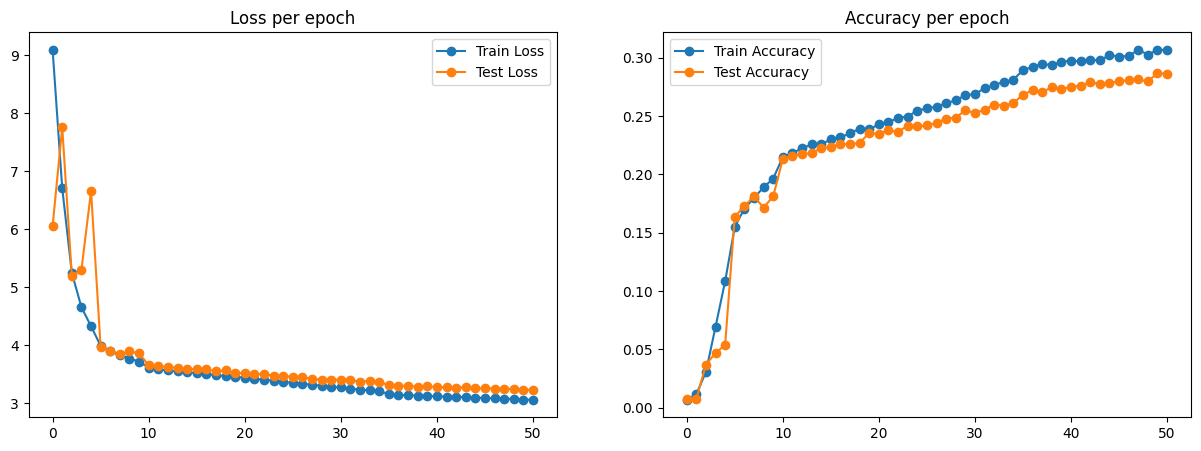

Saving best model

 		 ------------------------------ EPOCH: 52 ------------------------------
[05:40:36] Step 20/176: train loss = 3.0191
[05:40:46] Step 40/176: train loss = 3.03921
[05:40:55] Step 60/176: train loss = 3.04662
[05:41:04] Step 80/176: train loss = 3.04743
[05:41:15] Step 100/176: train loss = 3.04762
[05:41:24] Step 120/176: train loss = 3.05548
[05:41:34] Step 140/176: train loss = 3.05032
[05:41:44] Step 160/176: train loss = 3.04926
Train loss = 3.0506, accuracy = 0.30903, lr: 0.0001
VALIDATION LOSS = 3.24131, VALIDATION ACCURACY = 0.2829
LR: [0.0001]


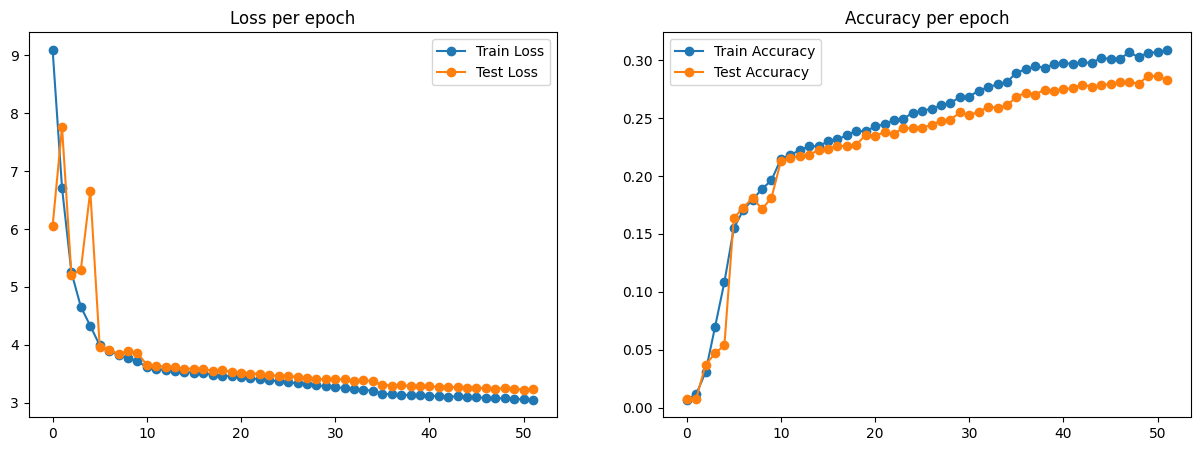

Validation loss didn't improve

 		 ------------------------------ EPOCH: 53 ------------------------------
[05:42:04] Step 20/176: train loss = 3.02634
[05:42:14] Step 40/176: train loss = 3.0531
[05:42:24] Step 60/176: train loss = 3.04472
[05:42:34] Step 80/176: train loss = 3.04228
[05:42:44] Step 100/176: train loss = 3.04211
[05:42:53] Step 120/176: train loss = 3.04152
[05:43:03] Step 140/176: train loss = 3.04534
[05:43:12] Step 160/176: train loss = 3.0502
Train loss = 3.04923, accuracy = 0.30883, lr: 0.0001
VALIDATION LOSS = 3.23193, VALIDATION ACCURACY = 0.2836
LR: [0.0001]


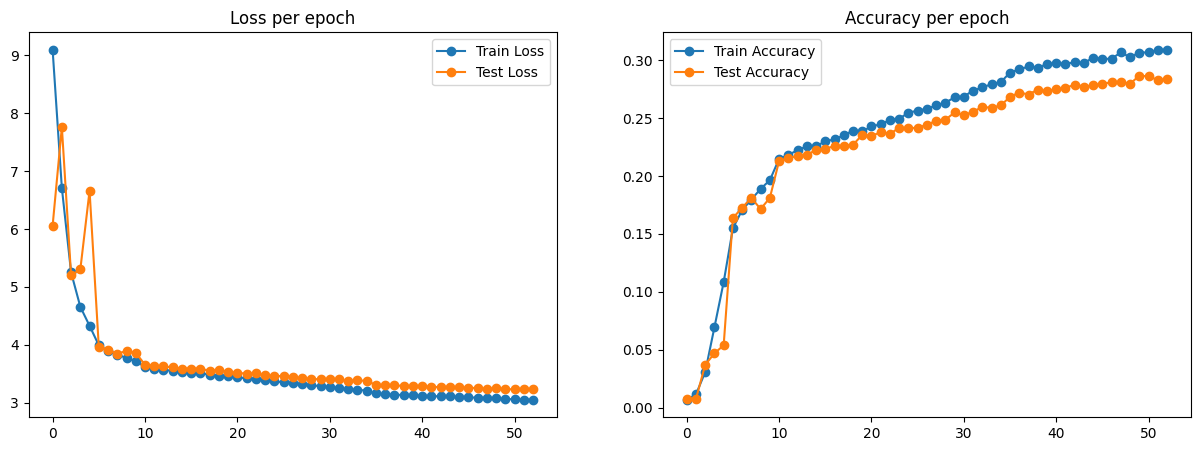

Validation loss didn't improve

 		 ------------------------------ EPOCH: 54 ------------------------------
[05:43:32] Step 20/176: train loss = 3.02629
[05:43:42] Step 40/176: train loss = 3.0233
[05:43:51] Step 60/176: train loss = 3.03409
[05:44:00] Step 80/176: train loss = 3.03984
[05:44:11] Step 100/176: train loss = 3.03347
[05:44:19] Step 120/176: train loss = 3.03421
[05:44:29] Step 140/176: train loss = 3.03844
[05:44:38] Step 160/176: train loss = 3.03985
Train loss = 3.04157, accuracy = 0.30951, lr: 0.0001
VALIDATION LOSS = 3.24004, VALIDATION ACCURACY = 0.2829
LR: [0.0001]


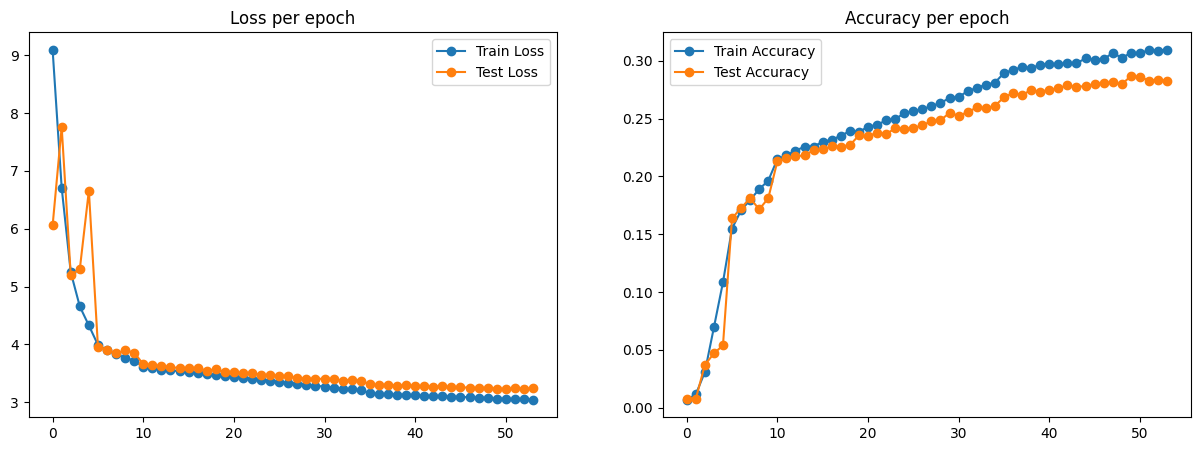

Validation loss didn't improve
EARLY STOPPING: min test_loss 3.22785, last 2 epochs min: 3.23193
Restoring the model at epoch 49: test_accuracy = 0.2861
Model successfully restored

 Training time: 77.0 minutes 48.19 seconds

 Final model is stored to model_epoch_50_test_acc_0.2861.pth


In [22]:
history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': [],
    
}
t1 = monotonic()
for epoch in range(train_config['n_epochs']):
    print('\n', '\t\t', '-' * 30, f"EPOCH: {epoch + 1}", '-' * 30)

    # Train
    model.train()
    model.to(DEVICE)
    train_avg_loss, train_accuracy = do_train_epoch(model, 
                                                    criterion, 
                                                    optimizer, 
                                                    train_dataloader, 
                                                    verbose=20)

    history['train_loss'].append(train_avg_loss)
    history['train_accuracy'].append(train_accuracy)

    # Val
    model.eval()
    val_avg_loss, val_accuracy = do_val_epoch(model, 
                                              criterion, 
                                              val_dataloader)
    scheduler.step(val_avg_loss)
    print(f"LR: {scheduler.get_last_lr()}")
    history['test_loss'].append(val_avg_loss)
    history['test_accuracy'].append(val_accuracy)

    # on_epoch_end events
    plot_history(history)
    
    # model checkpointing
    if history['test_loss'][-1] == min(history['test_loss']):
        print('Saving best model')
        torch.save(model.state_dict(), best_checkpoint_path)
    else:
        print("Validation loss didn't improve")

    # early stopping
    if min(history['test_loss'][-3:]) > min(history['test_loss']):
        best_epoch = np.argmin(history['test_loss'])
        best_test_accuracy = history['test_accuracy'][best_epoch]

        print(f'EARLY STOPPING: min test_loss {min(history["test_loss"])}, last 2 epochs min: {min(history["test_loss"][-3:])}')
        print(f'Restoring the model at epoch {best_epoch - 1}: test_accuracy = {best_test_accuracy}')

        model.load_state_dict(torch.load(best_checkpoint_path, weights_only=True))
        print('Model successfully restored')
        break
    # if epoch == 10:
    #     for g in optimizer.param_groups:
    #         g['lr'] = 0.001
t2 = monotonic()
m, s = divmod(t2 - t1, 60)
    # lr_adjustments (todo)


# saving the best model to hard storage
model_file_name = f'model_epoch_{best_epoch}_test_acc_{best_test_accuracy}.pth'
torch.save(model.state_dict(), f'../working/{model_file_name}')

print(f'\n Training time: {m} minutes {round(s, 2)} seconds')
print(f'\n Final model is stored to {model_file_name}')
os.remove(best_checkpoint_path)

### Make a prediction and prepare submission file

In [23]:
import pandas as pd

In [24]:
class TestDataset(Dataset):
    def __init__(self, 
                 img_dir: str, 
                 file_names: list[str],
                 transform=None):
        self.img_dir = img_dir
        self.file_names = file_names
        self.image_ids = [int(n.split('.')[0].split('_')[1]) for n in file_names]
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path).convert('RGB')

        img_id = self.image_ids[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, img_id

In [25]:
test_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/val'
test_image_names = sorted(os.listdir(f'{test_folder}/images'))
len(test_image_names)

10000

In [26]:
test_dataset = TestDataset(f'{test_folder}/images', test_image_names, transform=val_img_transform)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=128)

In [27]:
model.eval()

test_predictions = pd.Series([-1] * len(test_dataset))

total_steps = len(test_dataloader)
step = 0

with torch.no_grad():
    for X, img_ids in test_dataloader:
        preds = model(X.to(DEVICE)).cpu()
        
        probs = F.softmax(preds, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)

        # predicted_labels = torch.tensor([0] * X.shape[0])

        test_predictions.loc[img_ids] = predicted_labels.numpy()
        step += 1

        if step % 10 == 0:
            cur_time = datetime.now().strftime("%H:%M:%S")
            print(f"[{cur_time}] Step {step}/{total_steps} done")

[05:44:49] Step 10/79 done
[05:44:49] Step 20/79 done
[05:44:50] Step 30/79 done
[05:44:50] Step 40/79 done
[05:44:51] Step 50/79 done
[05:44:51] Step 60/79 done
[05:44:52] Step 70/79 done


In [28]:
test_predictions_df = (test_predictions
                       .reset_index()
                       .rename(columns={'index': 'ID', 0: 'class'}))
test_predictions_df.head()

,ID,class
0,0,97
1,1,36
2,2,66
3,3,142
4,4,92


In [29]:
# here we will do some analysis to ensure predictions file looks reasonable
(test_predictions_df['class'] < 0).sum()

np.int64(0)

In [30]:
test_predictions_df['class'].value_counts()

class
146    86
38     84
110    81
96     81
14     79
       ..
167    13
176    12
164    12
166     6
39      4
Name: count, Length: 200, dtype: int64

In [31]:
test_predictions_df['class'] = test_predictions_df['class'].map(class_id_to_name_dict)
test_predictions_df['ID'] = test_predictions_df['ID'].apply(lambda v: f'val_{v}.JPEG')

In [32]:
test_predictions_df.head()

,ID,class
0,val_0.JPEG,n03977966
1,val_1.JPEG,n01742172
2,val_2.JPEG,n03014705
3,val_3.JPEG,n02808440
4,val_4.JPEG,n04099969


In [33]:
test_predictions_df.to_csv(f'../working/submission_{model_file_name}.csv', index=False)